# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()
farthest_point = manager.dict()

# Non shared resources
filename = 'netifier-coreset-kfold'
epochs = 10
batch_size = 32
sequence_length = 96
min_increment = 200

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier-2/netifier/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-2/netifier/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


# BUILD DATASET & DATALOADERS

In [8]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [10]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [11]:
def train_model(current_train_size, train_indices, metrics, trials, seed, X_train_fold, y_train_fold, X_val_fold, y_val_fold, label_columns):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(f"Fold {trials + 1} - Training with {current_train_size} samples...")

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders using the fold's data
    current_X_train = [X_train_fold[i] for i in train_indices]
    current_y_train = [y_train_fold[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val_fold, y_val_fold)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-fold-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result
        
        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Best result for {current_train_size} samples: F1 Micro: {round(best_result['f1_micro'], 4)}")
    accelerator.print(best_result['report'])
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [12]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [13]:
def coreset_sampling(model, farthest_point, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, X_train_fold, y_train_fold, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        shuffle=False,
    )
    farthest_data = dict(farthest_point)
    
    model.eval()
    start_time = time.time()
    embeddings = []
    
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)

        hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
        embeddings.append(hidden_states.cpu().numpy())

    if 'input_ids' in farthest_data:
        with torch.no_grad():
            outputs = model.base_model(
                input_ids=farthest_data['input_ids'].unsqueeze(0).to(device, non_blocking=True), 
                attention_mask=farthest_data['attention_mask'].unsqueeze(0).to(device, non_blocking=True)
            )
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        # Use pairwise distances to compute a distance matrix for Coreset selection
        distance_matrix = pairwise_distances(embeddings)    
        selected_indices = distance_matrix.shape[0] - 1 if 'input_ids' in farthest_data else 0
        
        # Calculate the minimum distance from selected points to all other points
        min_distances = distance_matrix[selected_indices]

        sorted_dist = np.argsort(min_distances)
        sorted_dist = sorted_dist[::-1]
        farthest_point['input_ids'] = dataset[sorted_dist[0]]['input_ids']
        farthest_point['attention_mask'] = dataset[sorted_dist[0]]['attention_mask']
                
        threshold = np.percentile(min_distances, 90)
        candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
        num_of_candidates = len(candidates)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = sorted_dist[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             selected_indices = sorted_dist[:max(n_samples, min(math.ceil(0.1*len(sorted_dist)), num_of_candidates))]
        else:
            selected_indices = sorted_dist[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in selected_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train_fold[i] for i in temp],
                'pornografi': [y_train_fold[i][0] for i in temp],
                'sara': [y_train_fold[i][1] for i in temp],
                'radikalisme': [y_train_fold[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train_fold[i][3] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in selected_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [14]:
from sklearn.model_selection import KFold

N_SPLITS = 5
RANDOM_SEED = 42

# Prepare data for K-Fold
label_columns = data.columns[2:6]
X = data['processed_text'].values
y = data[label_columns].values
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

all_fold_accuracies = []
all_fold_f1_micros = []
all_fold_f1_macros = []
all_fold_data_used = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    if fold < 3:
        print("===============================================")
        print(f"STARTING FOLD {fold + 1}/{N_SPLITS}")
        print("===============================================")
    
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
    
        train_fold_df = pd.DataFrame(X_train_fold, columns=['processed_text'])
        train_fold_df[label_columns] = y_train_fold
    
        val_fold_df = pd.DataFrame(X_val_fold, columns=['processed_text'])
        val_fold_df[label_columns] = y_val_fold
    
        fold_data_dir = 'kfold_splits'
        if not os.path.exists(fold_data_dir):
            os.makedirs(fold_data_dir)
    
        train_fold_df.to_csv(f'{fold_data_dir}/train_fold_{fold + 1}.csv', index=False)
        val_fold_df.to_csv(f'{fold_data_dir}/val_fold_{fold + 1}.csv', index=False)
    
        # Shared resources for this fold's processes
        accuracies = manager.list()
        f1_micros = manager.list()
        f1_macros = manager.list()
        data_used = manager.list()
        sampling_dur = manager.list()
        farthest_point = manager.dict()
        
        set_seed(RANDOM_SEED + fold)
        
        # Define the initial labeled pool from the current fold's training data
        total_train_fold_size = len(X_train_fold) + len(X_val_fold)
        initial_train_size = int(0.05 * total_train_fold_size)
        
        train_indices = np.random.choice(range(len(X_train_fold)), initial_train_size, replace=False).tolist()
        remaining_indices = list(set(range(len(X_train_fold))) - set(train_indices))
        current_train_size = initial_train_size
    
        checkpoints = [
            # int(0.1 * total_train_fold_size),
            int(0.5 * total_train_fold_size), 
            int(0.6 * total_train_fold_size),
            int(0.7 * total_train_fold_size),
            len(X_train_fold)
        ]
        
        fold_start_time = time.time()
        
        while current_train_size < total_train_fold_size:
            # Train the model on the current labeled set
            train_args = (
                current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros),
                fold, RANDOM_SEED + fold, X_train_fold, y_train_fold, X_val_fold, y_val_fold, label_columns
            )
            notebook_launcher(train_model, train_args, num_processes=2)
            
            # Stop if we've reached the last checkpoint
            if current_train_size >= checkpoints[-1]:
                break
    
            model = BertForSequenceClassification.from_pretrained(f'{filename}-fold-{fold + 1}-model')
            
            # Perform query strategy to select new samples
            new_samples_shared = manager.list()
            X_pool = [X_train_fold[i] for i in remaining_indices]
            sampling_args = (model, farthest_point, X_pool, train_indices, remaining_indices, sampling_dur, new_samples_shared, fold, X_train_fold, y_train_fold)
            notebook_launcher(coreset_sampling, sampling_args, num_processes=2)
            
            # Update the pools
            newly_acquired_indices = list(new_samples_shared)
            train_indices.extend(newly_acquired_indices)
            remaining_indices = list(set(remaining_indices) - set(newly_acquired_indices))
        
            current_train_size = len(train_indices)
            print(f"\nFold {fold + 1} - New train size: {current_train_size}\n")
        
        fold_end_time = time.time()
        print(f"\nFOLD {fold + 1} COMPLETED in {fold_end_time - fold_start_time:.2f} seconds")
        
        # Store the results for this fold
        all_fold_data_used.append(list(data_used))
        all_fold_accuracies.append(list(accuracies))
        all_fold_f1_micros.append(list(f1_micros))
        all_fold_f1_macros.append(list(f1_macros))

STARTING FOLD 1/5
Launching training on 2 GPUs.
Fold 1 - Training with 388 samples...


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5963, Accuracy: 0.7902, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.5233, Accuracy: 0.7902, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.4851, Accuracy: 0.8166, F1 Micro: 0.2367, F1 Macro: 0.1613
Epoch 4/10, Train Loss: 0.4274, Accuracy: 0.8252, F1 Micro: 0.3327, F1 Macro: 0.227
Epoch 5/10, Train Loss: 0.3978, Accuracy: 0.8386, F1 Micro: 0.4661, F1 Macro: 0.3619
Epoch 6/10, Train Loss: 0.349, Accuracy: 0.8506, F1 Micro: 0.5631, F1 Macro: 0.5253
Epoch 7/10, Train Loss: 0.3106, Accuracy: 0.862, F1 Micro: 0.652, F1 Macro: 0.6434
Epoch 8/10, Train Loss: 0.2486, Accuracy: 0.8617, F1 Micro: 0.6641, F1 Macro: 0.6497
Epoch 9/10, Train Loss: 0.2302, Accuracy: 0.8678, F1 Micro: 0.6874, F1 Macro: 0.684
Epoch 10/10, Train Loss: 0.1741, Accuracy: 0.8681, F1 Micro: 0.6544, F1 Macro: 0.6387
Best result for 388 samples: F1 Micro: 0.6874
                      precision    recall  f1-score   support

          pornografi       0.91      0.79      0.85      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4499, Accuracy: 0.8048, F1 Micro: 0.3367, F1 Macro: 0.1928
Epoch 2/10, Train Loss: 0.2607, Accuracy: 0.8277, F1 Micro: 0.35, F1 Macro: 0.2316
Epoch 3/10, Train Loss: 0.1852, Accuracy: 0.8444, F1 Micro: 0.5489, F1 Macro: 0.4815
Epoch 4/10, Train Loss: 0.1631, Accuracy: 0.8517, F1 Micro: 0.6431, F1 Macro: 0.6279
Epoch 5/10, Train Loss: 0.1301, Accuracy: 0.8539, F1 Micro: 0.6609, F1 Macro: 0.6471
Epoch 6/10, Train Loss: 0.1052, Accuracy: 0.8589, F1 Micro: 0.6455, F1 Macro: 0.6258
Epoch 7/10, Train Loss: 0.1019, Accuracy: 0.8623, F1 Micro: 0.6491, F1 Macro: 0.6155
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.8687, F1 Micro: 0.6532, F1 Macro: 0.6318
Epoch 9/10, Train Loss: 0.061, Accuracy: 0.8675, F1 Micro: 0.6677, F1 Macro: 0.6585
Epoch 10/10, Train Loss: 0.0467, Accuracy: 0.8669, F1 Micro: 0.6748, F1 Macro: 0.6623
Best result for 971 samples: F1 Micro: 0.6748
                      precision    recall  f1-score   support

          pornografi       0.86      0.84  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4946, Accuracy: 0.8033, F1 Micro: 0.5821, F1 Macro: 0.5875
Epoch 2/10, Train Loss: 0.3122, Accuracy: 0.8481, F1 Micro: 0.6541, F1 Macro: 0.6553
Epoch 3/10, Train Loss: 0.2604, Accuracy: 0.8662, F1 Micro: 0.6342, F1 Macro: 0.63
Epoch 4/10, Train Loss: 0.2148, Accuracy: 0.8717, F1 Micro: 0.6784, F1 Macro: 0.6698
Epoch 5/10, Train Loss: 0.1585, Accuracy: 0.8733, F1 Micro: 0.6836, F1 Macro: 0.6798
Epoch 6/10, Train Loss: 0.1283, Accuracy: 0.8734, F1 Micro: 0.6973, F1 Macro: 0.691
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.8739, F1 Micro: 0.6806, F1 Macro: 0.6719
Epoch 8/10, Train Loss: 0.0756, Accuracy: 0.8744, F1 Micro: 0.6732, F1 Macro: 0.6629
Epoch 9/10, Train Loss: 0.0677, Accuracy: 0.8748, F1 Micro: 0.6567, F1 Macro: 0.6414
Epoch 10/10, Train Loss: 0.053, Accuracy: 0.8748, F1 Micro: 0.6928, F1 Macro: 0.6861
Best result for 1496 samples: F1 Micro: 0.6973
                      precision    recall  f1-score   support

          pornografi       0.87      0.84  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4289, Accuracy: 0.8205, F1 Micro: 0.5918, F1 Macro: 0.5868
Epoch 2/10, Train Loss: 0.2744, Accuracy: 0.8677, F1 Micro: 0.6567, F1 Macro: 0.6369
Epoch 3/10, Train Loss: 0.2156, Accuracy: 0.8792, F1 Micro: 0.6912, F1 Macro: 0.6824
Epoch 4/10, Train Loss: 0.1713, Accuracy: 0.8775, F1 Micro: 0.6874, F1 Macro: 0.6652
Epoch 5/10, Train Loss: 0.1291, Accuracy: 0.8819, F1 Micro: 0.6733, F1 Macro: 0.6414
Epoch 6/10, Train Loss: 0.0996, Accuracy: 0.878, F1 Micro: 0.7011, F1 Macro: 0.6919
Epoch 7/10, Train Loss: 0.0753, Accuracy: 0.8872, F1 Micro: 0.6974, F1 Macro: 0.6788
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.88, F1 Micro: 0.7066, F1 Macro: 0.6921
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.882, F1 Micro: 0.7079, F1 Macro: 0.7032
Epoch 10/10, Train Loss: 0.0428, Accuracy: 0.8873, F1 Micro: 0.7178, F1 Macro: 0.7042
Best result for 1969 samples: F1 Micro: 0.7178
                      precision    recall  f1-score   support

          pornografi       0.91      0.86  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4503, Accuracy: 0.8497, F1 Micro: 0.6277, F1 Macro: 0.607
Epoch 2/10, Train Loss: 0.2788, Accuracy: 0.8755, F1 Micro: 0.6572, F1 Macro: 0.631
Epoch 3/10, Train Loss: 0.2278, Accuracy: 0.8784, F1 Micro: 0.6527, F1 Macro: 0.6318
Epoch 4/10, Train Loss: 0.1748, Accuracy: 0.8855, F1 Micro: 0.7055, F1 Macro: 0.6955
Epoch 5/10, Train Loss: 0.13, Accuracy: 0.8895, F1 Micro: 0.7075, F1 Macro: 0.6943
Epoch 6/10, Train Loss: 0.0987, Accuracy: 0.8908, F1 Micro: 0.7001, F1 Macro: 0.6785
Epoch 7/10, Train Loss: 0.081, Accuracy: 0.8867, F1 Micro: 0.7145, F1 Macro: 0.7049
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.887, F1 Micro: 0.7301, F1 Macro: 0.7238
Epoch 9/10, Train Loss: 0.0509, Accuracy: 0.8867, F1 Micro: 0.7296, F1 Macro: 0.7197
Epoch 10/10, Train Loss: 0.0429, Accuracy: 0.89, F1 Micro: 0.7184, F1 Macro: 0.7088
Best result for 2394 samples: F1 Micro: 0.7301
                      precision    recall  f1-score   support

          pornografi       0.87      0.89      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4233, Accuracy: 0.8558, F1 Micro: 0.6492, F1 Macro: 0.6412
Epoch 2/10, Train Loss: 0.2568, Accuracy: 0.8828, F1 Micro: 0.7026, F1 Macro: 0.6846
Epoch 3/10, Train Loss: 0.2061, Accuracy: 0.8908, F1 Micro: 0.7173, F1 Macro: 0.7054
Epoch 4/10, Train Loss: 0.1666, Accuracy: 0.892, F1 Micro: 0.7295, F1 Macro: 0.7194
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.8894, F1 Micro: 0.732, F1 Macro: 0.7198
Epoch 6/10, Train Loss: 0.0836, Accuracy: 0.8925, F1 Micro: 0.7082, F1 Macro: 0.6892
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.8891, F1 Micro: 0.7044, F1 Macro: 0.6918
Epoch 8/10, Train Loss: 0.0566, Accuracy: 0.8884, F1 Micro: 0.7281, F1 Macro: 0.7177
Epoch 9/10, Train Loss: 0.0447, Accuracy: 0.8913, F1 Micro: 0.7329, F1 Macro: 0.722
Epoch 10/10, Train Loss: 0.0335, Accuracy: 0.8923, F1 Micro: 0.7123, F1 Macro: 0.6947
Best result for 2777 samples: F1 Micro: 0.7329
                      precision    recall  f1-score   support

          pornografi       0.91      0.89   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4296, Accuracy: 0.8694, F1 Micro: 0.6729, F1 Macro: 0.6622
Epoch 2/10, Train Loss: 0.254, Accuracy: 0.8892, F1 Micro: 0.7266, F1 Macro: 0.7123
Epoch 3/10, Train Loss: 0.2064, Accuracy: 0.8914, F1 Micro: 0.7134, F1 Macro: 0.7009
Epoch 4/10, Train Loss: 0.1627, Accuracy: 0.8928, F1 Micro: 0.7241, F1 Macro: 0.7129
Epoch 5/10, Train Loss: 0.1286, Accuracy: 0.8919, F1 Micro: 0.7347, F1 Macro: 0.7251
Epoch 6/10, Train Loss: 0.0939, Accuracy: 0.8933, F1 Micro: 0.7386, F1 Macro: 0.7257
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.8942, F1 Micro: 0.7475, F1 Macro: 0.744
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.8967, F1 Micro: 0.7242, F1 Macro: 0.7057
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.8938, F1 Micro: 0.7381, F1 Macro: 0.7315
Epoch 10/10, Train Loss: 0.0394, Accuracy: 0.8955, F1 Micro: 0.7436, F1 Macro: 0.7372
Best result for 3122 samples: F1 Micro: 0.7475
                      precision    recall  f1-score   support

          pornografi       0.92      0.86 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4085, Accuracy: 0.8687, F1 Micro: 0.6651, F1 Macro: 0.6492
Epoch 2/10, Train Loss: 0.2402, Accuracy: 0.887, F1 Micro: 0.706, F1 Macro: 0.6951
Epoch 3/10, Train Loss: 0.1963, Accuracy: 0.8952, F1 Micro: 0.7285, F1 Macro: 0.7162
Epoch 4/10, Train Loss: 0.1539, Accuracy: 0.8984, F1 Micro: 0.74, F1 Macro: 0.7225
Epoch 5/10, Train Loss: 0.113, Accuracy: 0.8969, F1 Micro: 0.7452, F1 Macro: 0.7371
Epoch 6/10, Train Loss: 0.0835, Accuracy: 0.8983, F1 Micro: 0.7446, F1 Macro: 0.7349
Epoch 7/10, Train Loss: 0.0656, Accuracy: 0.8964, F1 Micro: 0.749, F1 Macro: 0.7476
Epoch 8/10, Train Loss: 0.0526, Accuracy: 0.8967, F1 Micro: 0.7431, F1 Macro: 0.7345
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.8952, F1 Micro: 0.7412, F1 Macro: 0.7356
Epoch 10/10, Train Loss: 0.0349, Accuracy: 0.8947, F1 Micro: 0.7346, F1 Macro: 0.7285
Best result for 3432 samples: F1 Micro: 0.749
                      precision    recall  f1-score   support

          pornografi       0.96      0.83     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4066, Accuracy: 0.8652, F1 Micro: 0.6805, F1 Macro: 0.6692
Epoch 2/10, Train Loss: 0.2433, Accuracy: 0.8889, F1 Micro: 0.6907, F1 Macro: 0.6776
Epoch 3/10, Train Loss: 0.1916, Accuracy: 0.8917, F1 Micro: 0.7466, F1 Macro: 0.7388
Epoch 4/10, Train Loss: 0.1493, Accuracy: 0.8989, F1 Micro: 0.7448, F1 Macro: 0.734
Epoch 5/10, Train Loss: 0.1149, Accuracy: 0.9013, F1 Micro: 0.7462, F1 Macro: 0.7389
Epoch 6/10, Train Loss: 0.0858, Accuracy: 0.8994, F1 Micro: 0.7463, F1 Macro: 0.7353
Epoch 7/10, Train Loss: 0.0639, Accuracy: 0.8988, F1 Micro: 0.7504, F1 Macro: 0.7426
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.8995, F1 Micro: 0.756, F1 Macro: 0.7498
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.8992, F1 Micro: 0.7495, F1 Macro: 0.7449
Epoch 10/10, Train Loss: 0.0352, Accuracy: 0.8944, F1 Micro: 0.7468, F1 Macro: 0.7438
Best result for 3711 samples: F1 Micro: 0.756
                      precision    recall  f1-score   support

          pornografi       0.92      0.88   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3924, Accuracy: 0.8756, F1 Micro: 0.6798, F1 Macro: 0.6686
Epoch 2/10, Train Loss: 0.231, Accuracy: 0.8911, F1 Micro: 0.7142, F1 Macro: 0.706
Epoch 3/10, Train Loss: 0.1837, Accuracy: 0.8956, F1 Micro: 0.7522, F1 Macro: 0.744
Epoch 4/10, Train Loss: 0.1476, Accuracy: 0.9003, F1 Micro: 0.7328, F1 Macro: 0.7174
Epoch 5/10, Train Loss: 0.1073, Accuracy: 0.8973, F1 Micro: 0.7418, F1 Macro: 0.7307
Epoch 6/10, Train Loss: 0.0815, Accuracy: 0.897, F1 Micro: 0.7512, F1 Macro: 0.7465
Epoch 7/10, Train Loss: 0.0638, Accuracy: 0.8958, F1 Micro: 0.7523, F1 Macro: 0.7489
Epoch 8/10, Train Loss: 0.0498, Accuracy: 0.897, F1 Micro: 0.7378, F1 Macro: 0.7256
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.8992, F1 Micro: 0.7454, F1 Macro: 0.7396
Epoch 10/10, Train Loss: 0.0343, Accuracy: 0.8925, F1 Micro: 0.7522, F1 Macro: 0.7511
Best result for 3886 samples: F1 Micro: 0.7523
                      precision    recall  f1-score   support

          pornografi       0.92      0.88   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3899, Accuracy: 0.8736, F1 Micro: 0.6441, F1 Macro: 0.6296
Epoch 2/10, Train Loss: 0.2374, Accuracy: 0.8928, F1 Micro: 0.7349, F1 Macro: 0.7225
Epoch 3/10, Train Loss: 0.186, Accuracy: 0.8955, F1 Micro: 0.7304, F1 Macro: 0.7084
Epoch 4/10, Train Loss: 0.1501, Accuracy: 0.9039, F1 Micro: 0.7664, F1 Macro: 0.763
Epoch 5/10, Train Loss: 0.1131, Accuracy: 0.9, F1 Micro: 0.7324, F1 Macro: 0.7232
Epoch 6/10, Train Loss: 0.089, Accuracy: 0.9003, F1 Micro: 0.7504, F1 Macro: 0.7487
Epoch 7/10, Train Loss: 0.062, Accuracy: 0.8986, F1 Micro: 0.746, F1 Macro: 0.738
Epoch 8/10, Train Loss: 0.0497, Accuracy: 0.9017, F1 Micro: 0.7567, F1 Macro: 0.7531
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.8964, F1 Micro: 0.7507, F1 Macro: 0.7467
Epoch 10/10, Train Loss: 0.0313, Accuracy: 0.9048, F1 Micro: 0.7628, F1 Macro: 0.7602
Best result for 4120 samples: F1 Micro: 0.7664
                      precision    recall  f1-score   support

          pornografi       0.95      0.86      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4021, Accuracy: 0.8797, F1 Micro: 0.7013, F1 Macro: 0.6754
Epoch 2/10, Train Loss: 0.2312, Accuracy: 0.897, F1 Micro: 0.7443, F1 Macro: 0.7331
Epoch 3/10, Train Loss: 0.1878, Accuracy: 0.8961, F1 Micro: 0.7563, F1 Macro: 0.7514
Epoch 4/10, Train Loss: 0.1476, Accuracy: 0.9027, F1 Micro: 0.7586, F1 Macro: 0.7507
Epoch 5/10, Train Loss: 0.1191, Accuracy: 0.8998, F1 Micro: 0.7591, F1 Macro: 0.7524
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.9034, F1 Micro: 0.7618, F1 Macro: 0.7524
Epoch 7/10, Train Loss: 0.0665, Accuracy: 0.8998, F1 Micro: 0.7376, F1 Macro: 0.7255
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.8972, F1 Micro: 0.7473, F1 Macro: 0.7387
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.8997, F1 Micro: 0.7456, F1 Macro: 0.7401
Epoch 10/10, Train Loss: 0.0354, Accuracy: 0.9009, F1 Micro: 0.7535, F1 Macro: 0.7495
Best result for 4330 samples: F1 Micro: 0.7618
                      precision    recall  f1-score   support

          pornografi       0.91      0.90

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3962, Accuracy: 0.8753, F1 Micro: 0.7007, F1 Macro: 0.6925
Epoch 2/10, Train Loss: 0.2394, Accuracy: 0.8898, F1 Micro: 0.7459, F1 Macro: 0.7356
Epoch 3/10, Train Loss: 0.1967, Accuracy: 0.9017, F1 Micro: 0.7452, F1 Macro: 0.7437
Epoch 4/10, Train Loss: 0.1559, Accuracy: 0.9011, F1 Micro: 0.7526, F1 Macro: 0.744
Epoch 5/10, Train Loss: 0.1213, Accuracy: 0.9014, F1 Micro: 0.7678, F1 Macro: 0.7627
Epoch 6/10, Train Loss: 0.0897, Accuracy: 0.9023, F1 Micro: 0.7599, F1 Macro: 0.7569
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.9034, F1 Micro: 0.7629, F1 Macro: 0.7572
Epoch 8/10, Train Loss: 0.0522, Accuracy: 0.8983, F1 Micro: 0.7621, F1 Macro: 0.757
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9002, F1 Micro: 0.7558, F1 Macro: 0.7483
Epoch 10/10, Train Loss: 0.0307, Accuracy: 0.8997, F1 Micro: 0.7386, F1 Macro: 0.7301
Best result for 4530 samples: F1 Micro: 0.7678
                      precision    recall  f1-score   support

          pornografi       0.92      0.89

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3928, Accuracy: 0.8791, F1 Micro: 0.7097, F1 Macro: 0.6921
Epoch 2/10, Train Loss: 0.2358, Accuracy: 0.8927, F1 Micro: 0.7519, F1 Macro: 0.7503
Epoch 3/10, Train Loss: 0.1949, Accuracy: 0.9042, F1 Micro: 0.7605, F1 Macro: 0.7472
Epoch 4/10, Train Loss: 0.1566, Accuracy: 0.9028, F1 Micro: 0.7536, F1 Macro: 0.7455
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.9058, F1 Micro: 0.757, F1 Macro: 0.7519
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9064, F1 Micro: 0.7692, F1 Macro: 0.7632
Epoch 7/10, Train Loss: 0.0659, Accuracy: 0.9005, F1 Micro: 0.7473, F1 Macro: 0.7342
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9027, F1 Micro: 0.7581, F1 Macro: 0.7528
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.8947, F1 Micro: 0.7625, F1 Macro: 0.7615
Epoch 10/10, Train Loss: 0.0332, Accuracy: 0.9025, F1 Micro: 0.7587, F1 Macro: 0.7521
Best result for 4663 samples: F1 Micro: 0.7692
                      precision    recall  f1-score   support

          pornografi       0.91      0.91  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3874, Accuracy: 0.8834, F1 Micro: 0.6928, F1 Macro: 0.686
Epoch 2/10, Train Loss: 0.2363, Accuracy: 0.898, F1 Micro: 0.7362, F1 Macro: 0.7227
Epoch 3/10, Train Loss: 0.1937, Accuracy: 0.902, F1 Micro: 0.7501, F1 Macro: 0.74
Epoch 4/10, Train Loss: 0.1512, Accuracy: 0.903, F1 Micro: 0.7729, F1 Macro: 0.7723
Epoch 5/10, Train Loss: 0.1279, Accuracy: 0.9028, F1 Micro: 0.7587, F1 Macro: 0.7509
Epoch 6/10, Train Loss: 0.0841, Accuracy: 0.8972, F1 Micro: 0.7576, F1 Macro: 0.7492
Epoch 7/10, Train Loss: 0.0636, Accuracy: 0.903, F1 Micro: 0.7556, F1 Macro: 0.7427
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9008, F1 Micro: 0.7561, F1 Macro: 0.7491
Epoch 9/10, Train Loss: 0.0411, Accuracy: 0.8975, F1 Micro: 0.7496, F1 Macro: 0.7409
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.9005, F1 Micro: 0.7566, F1 Macro: 0.746
Best result for 4863 samples: F1 Micro: 0.7729
                      precision    recall  f1-score   support

          pornografi       0.95      0.88      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3952, Accuracy: 0.8798, F1 Micro: 0.6522, F1 Macro: 0.6268
Epoch 2/10, Train Loss: 0.2381, Accuracy: 0.895, F1 Micro: 0.7303, F1 Macro: 0.7263
Epoch 3/10, Train Loss: 0.2007, Accuracy: 0.9061, F1 Micro: 0.7662, F1 Macro: 0.7638
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.9036, F1 Micro: 0.7702, F1 Macro: 0.7708
Epoch 5/10, Train Loss: 0.1242, Accuracy: 0.903, F1 Micro: 0.7643, F1 Macro: 0.7611
Epoch 6/10, Train Loss: 0.0939, Accuracy: 0.9066, F1 Micro: 0.7621, F1 Macro: 0.7517
Epoch 7/10, Train Loss: 0.07, Accuracy: 0.903, F1 Micro: 0.7696, F1 Macro: 0.7674
Epoch 8/10, Train Loss: 0.0496, Accuracy: 0.9016, F1 Micro: 0.7632, F1 Macro: 0.76
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.9066, F1 Micro: 0.7651, F1 Macro: 0.7547
Epoch 10/10, Train Loss: 0.0333, Accuracy: 0.898, F1 Micro: 0.7645, F1 Macro: 0.7623
Best result for 5063 samples: F1 Micro: 0.7702
                      precision    recall  f1-score   support

          pornografi       0.96      0.87      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3854, Accuracy: 0.8816, F1 Micro: 0.7234, F1 Macro: 0.7135
Epoch 2/10, Train Loss: 0.2381, Accuracy: 0.8942, F1 Micro: 0.753, F1 Macro: 0.752
Epoch 3/10, Train Loss: 0.195, Accuracy: 0.9062, F1 Micro: 0.7656, F1 Macro: 0.7609
Epoch 4/10, Train Loss: 0.1545, Accuracy: 0.9087, F1 Micro: 0.7735, F1 Macro: 0.7666
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9092, F1 Micro: 0.7756, F1 Macro: 0.7673
Epoch 6/10, Train Loss: 0.0878, Accuracy: 0.9022, F1 Micro: 0.7648, F1 Macro: 0.7603
Epoch 7/10, Train Loss: 0.0665, Accuracy: 0.9002, F1 Micro: 0.7714, F1 Macro: 0.7711
Epoch 8/10, Train Loss: 0.047, Accuracy: 0.9048, F1 Micro: 0.7657, F1 Macro: 0.7644
Epoch 9/10, Train Loss: 0.037, Accuracy: 0.9038, F1 Micro: 0.7596, F1 Macro: 0.7573
Epoch 10/10, Train Loss: 0.0301, Accuracy: 0.9066, F1 Micro: 0.7721, F1 Macro: 0.7703
Best result for 5263 samples: F1 Micro: 0.7756
                      precision    recall  f1-score   support

          pornografi       0.95      0.90   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3807, Accuracy: 0.8816, F1 Micro: 0.7262, F1 Macro: 0.7222
Epoch 2/10, Train Loss: 0.2282, Accuracy: 0.8956, F1 Micro: 0.7571, F1 Macro: 0.7493
Epoch 3/10, Train Loss: 0.1902, Accuracy: 0.9033, F1 Micro: 0.7649, F1 Macro: 0.7623
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.907, F1 Micro: 0.7584, F1 Macro: 0.7506
Epoch 5/10, Train Loss: 0.1243, Accuracy: 0.9009, F1 Micro: 0.7686, F1 Macro: 0.7628
Epoch 6/10, Train Loss: 0.0866, Accuracy: 0.9073, F1 Micro: 0.7672, F1 Macro: 0.7557
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9055, F1 Micro: 0.7711, F1 Macro: 0.7671
Epoch 8/10, Train Loss: 0.0483, Accuracy: 0.9048, F1 Micro: 0.7569, F1 Macro: 0.7458
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9044, F1 Micro: 0.763, F1 Macro: 0.7533
Epoch 10/10, Train Loss: 0.0307, Accuracy: 0.9014, F1 Micro: 0.7611, F1 Macro: 0.7517
Best result for 5441 samples: F1 Micro: 0.7711
                      precision    recall  f1-score   support

          pornografi       0.94      0.90

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3674, Accuracy: 0.8756, F1 Micro: 0.7265, F1 Macro: 0.7242
Epoch 2/10, Train Loss: 0.2364, Accuracy: 0.8978, F1 Micro: 0.7712, F1 Macro: 0.7719
Epoch 3/10, Train Loss: 0.193, Accuracy: 0.9056, F1 Micro: 0.7819, F1 Macro: 0.7818
Epoch 4/10, Train Loss: 0.1532, Accuracy: 0.9055, F1 Micro: 0.7726, F1 Macro: 0.7722
Epoch 5/10, Train Loss: 0.1217, Accuracy: 0.9077, F1 Micro: 0.7789, F1 Macro: 0.7765
Epoch 6/10, Train Loss: 0.0885, Accuracy: 0.9036, F1 Micro: 0.7688, F1 Macro: 0.7654
Epoch 7/10, Train Loss: 0.0641, Accuracy: 0.9078, F1 Micro: 0.7824, F1 Macro: 0.7807
Epoch 8/10, Train Loss: 0.0457, Accuracy: 0.907, F1 Micro: 0.7576, F1 Macro: 0.7524
Epoch 9/10, Train Loss: 0.0372, Accuracy: 0.9106, F1 Micro: 0.7808, F1 Macro: 0.7759
Epoch 10/10, Train Loss: 0.0297, Accuracy: 0.9084, F1 Micro: 0.776, F1 Macro: 0.7727
Best result for 5641 samples: F1 Micro: 0.7824
                      precision    recall  f1-score   support

          pornografi       0.93      0.91 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3613, Accuracy: 0.8853, F1 Micro: 0.7263, F1 Macro: 0.7147
Epoch 2/10, Train Loss: 0.2379, Accuracy: 0.8984, F1 Micro: 0.7394, F1 Macro: 0.7251
Epoch 3/10, Train Loss: 0.1972, Accuracy: 0.9069, F1 Micro: 0.7788, F1 Macro: 0.7764
Epoch 4/10, Train Loss: 0.1574, Accuracy: 0.9005, F1 Micro: 0.7734, F1 Macro: 0.7705
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.8973, F1 Micro: 0.7702, F1 Macro: 0.7682
Epoch 6/10, Train Loss: 0.0915, Accuracy: 0.9103, F1 Micro: 0.774, F1 Macro: 0.7698
Epoch 7/10, Train Loss: 0.0663, Accuracy: 0.9016, F1 Micro: 0.7747, F1 Macro: 0.7734
Epoch 8/10, Train Loss: 0.0472, Accuracy: 0.9027, F1 Micro: 0.7729, F1 Macro: 0.7702
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9053, F1 Micro: 0.7706, F1 Macro: 0.7629
Epoch 10/10, Train Loss: 0.0307, Accuracy: 0.9042, F1 Micro: 0.7725, F1 Macro: 0.7688
Best result for 5841 samples: F1 Micro: 0.7788
                      precision    recall  f1-score   support

          pornografi       0.95      0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3704, Accuracy: 0.8872, F1 Micro: 0.724, F1 Macro: 0.72
Epoch 2/10, Train Loss: 0.2389, Accuracy: 0.9008, F1 Micro: 0.7583, F1 Macro: 0.7465
Epoch 3/10, Train Loss: 0.1898, Accuracy: 0.9058, F1 Micro: 0.7754, F1 Macro: 0.7727
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.9062, F1 Micro: 0.7734, F1 Macro: 0.77
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.9028, F1 Micro: 0.7758, F1 Macro: 0.7747
Epoch 6/10, Train Loss: 0.0872, Accuracy: 0.9056, F1 Micro: 0.775, F1 Macro: 0.7738
Epoch 7/10, Train Loss: 0.0644, Accuracy: 0.9067, F1 Micro: 0.7795, F1 Macro: 0.7782
Epoch 8/10, Train Loss: 0.0458, Accuracy: 0.8998, F1 Micro: 0.7731, F1 Macro: 0.7723
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.9011, F1 Micro: 0.7735, F1 Macro: 0.7738
Epoch 10/10, Train Loss: 0.0263, Accuracy: 0.9066, F1 Micro: 0.779, F1 Macro: 0.7787
Best result for 6041 samples: F1 Micro: 0.7795
                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3646, Accuracy: 0.8828, F1 Micro: 0.7275, F1 Macro: 0.7198
Epoch 2/10, Train Loss: 0.2387, Accuracy: 0.9003, F1 Micro: 0.7625, F1 Macro: 0.7571
Epoch 3/10, Train Loss: 0.2034, Accuracy: 0.9022, F1 Micro: 0.7707, F1 Macro: 0.7652
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.9061, F1 Micro: 0.7558, F1 Macro: 0.7495
Epoch 5/10, Train Loss: 0.1176, Accuracy: 0.9075, F1 Micro: 0.7684, F1 Macro: 0.7553
Epoch 6/10, Train Loss: 0.0896, Accuracy: 0.9042, F1 Micro: 0.7707, F1 Macro: 0.7622
Epoch 7/10, Train Loss: 0.0601, Accuracy: 0.9047, F1 Micro: 0.7705, F1 Macro: 0.7667
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.9025, F1 Micro: 0.7714, F1 Macro: 0.7682
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.9019, F1 Micro: 0.7765, F1 Macro: 0.7751
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.9038, F1 Micro: 0.7658, F1 Macro: 0.7613
Best result for 6218 samples: F1 Micro: 0.7765
                      precision    recall  f1-score   support

          pornografi       0.93      0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5615, Accuracy: 0.7841, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.4954, Accuracy: 0.7953, F1 Micro: 0.099, F1 Macro: 0.08
Epoch 3/10, Train Loss: 0.448, Accuracy: 0.8238, F1 Micro: 0.3229, F1 Macro: 0.2108
Epoch 4/10, Train Loss: 0.3886, Accuracy: 0.8323, F1 Micro: 0.3975, F1 Macro: 0.3047
Epoch 5/10, Train Loss: 0.3358, Accuracy: 0.8384, F1 Micro: 0.4615, F1 Macro: 0.3692
Epoch 6/10, Train Loss: 0.2851, Accuracy: 0.8464, F1 Micro: 0.5131, F1 Macro: 0.4513
Epoch 7/10, Train Loss: 0.2509, Accuracy: 0.8661, F1 Micro: 0.6355, F1 Macro: 0.5946
Epoch 8/10, Train Loss: 0.2376, Accuracy: 0.872, F1 Micro: 0.6667, F1 Macro: 0.6441
Epoch 9/10, Train Loss: 0.188, Accuracy: 0.8628, F1 Micro: 0.6132, F1 Macro: 0.5838
Epoch 10/10, Train Loss: 0.1613, Accuracy: 0.8709, F1 Micro: 0.6541, F1 Macro: 0.628
Best result for 388 samples: F1 Micro: 0.6667
                      precision    recall  f1-score   support

          pornografi       0.94      0.80      0.86  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4135, Accuracy: 0.8175, F1 Micro: 0.3364, F1 Macro: 0.1958
Epoch 2/10, Train Loss: 0.2375, Accuracy: 0.8277, F1 Micro: 0.3523, F1 Macro: 0.2151
Epoch 3/10, Train Loss: 0.1702, Accuracy: 0.8305, F1 Micro: 0.3935, F1 Macro: 0.2604
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.8461, F1 Micro: 0.5058, F1 Macro: 0.459
Epoch 5/10, Train Loss: 0.1295, Accuracy: 0.8598, F1 Micro: 0.5857, F1 Macro: 0.5392
Epoch 6/10, Train Loss: 0.1091, Accuracy: 0.8709, F1 Micro: 0.6506, F1 Macro: 0.6212
Epoch 7/10, Train Loss: 0.0805, Accuracy: 0.8773, F1 Micro: 0.7025, F1 Macro: 0.698
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.875, F1 Micro: 0.6745, F1 Macro: 0.6476
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.8763, F1 Micro: 0.6814, F1 Macro: 0.6592
Epoch 10/10, Train Loss: 0.0454, Accuracy: 0.8744, F1 Micro: 0.6694, F1 Macro: 0.6431
Best result for 971 samples: F1 Micro: 0.7025
                      precision    recall  f1-score   support

          pornografi       0.94      0.83  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4512, Accuracy: 0.8062, F1 Micro: 0.5575, F1 Macro: 0.5453
Epoch 2/10, Train Loss: 0.2942, Accuracy: 0.8569, F1 Micro: 0.5947, F1 Macro: 0.5731
Epoch 3/10, Train Loss: 0.2362, Accuracy: 0.8686, F1 Micro: 0.6497, F1 Macro: 0.6404
Epoch 4/10, Train Loss: 0.2078, Accuracy: 0.8808, F1 Micro: 0.7202, F1 Macro: 0.7105
Epoch 5/10, Train Loss: 0.1719, Accuracy: 0.8836, F1 Micro: 0.7238, F1 Macro: 0.7201
Epoch 6/10, Train Loss: 0.1353, Accuracy: 0.8836, F1 Micro: 0.705, F1 Macro: 0.6974
Epoch 7/10, Train Loss: 0.104, Accuracy: 0.8839, F1 Micro: 0.713, F1 Macro: 0.6902
Epoch 8/10, Train Loss: 0.0785, Accuracy: 0.8811, F1 Micro: 0.6851, F1 Macro: 0.6647
Epoch 9/10, Train Loss: 0.0615, Accuracy: 0.8839, F1 Micro: 0.7197, F1 Macro: 0.7027
Epoch 10/10, Train Loss: 0.0536, Accuracy: 0.8814, F1 Micro: 0.7225, F1 Macro: 0.7095
Best result for 1496 samples: F1 Micro: 0.7238
                      precision    recall  f1-score   support

          pornografi       0.95      0.84 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4245, Accuracy: 0.8136, F1 Micro: 0.5885, F1 Macro: 0.5851
Epoch 2/10, Train Loss: 0.2764, Accuracy: 0.8652, F1 Micro: 0.6453, F1 Macro: 0.6309
Epoch 3/10, Train Loss: 0.2178, Accuracy: 0.8845, F1 Micro: 0.6987, F1 Macro: 0.6604
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.8881, F1 Micro: 0.7288, F1 Macro: 0.7113
Epoch 5/10, Train Loss: 0.1312, Accuracy: 0.8903, F1 Micro: 0.74, F1 Macro: 0.7304
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.8847, F1 Micro: 0.6922, F1 Macro: 0.661
Epoch 7/10, Train Loss: 0.0807, Accuracy: 0.8858, F1 Micro: 0.7148, F1 Macro: 0.6942
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.885, F1 Micro: 0.6966, F1 Macro: 0.6703
Epoch 9/10, Train Loss: 0.054, Accuracy: 0.888, F1 Micro: 0.7131, F1 Macro: 0.6936
Epoch 10/10, Train Loss: 0.0499, Accuracy: 0.8908, F1 Micro: 0.7416, F1 Macro: 0.7302
Best result for 1969 samples: F1 Micro: 0.7416
                      precision    recall  f1-score   support

          pornografi       0.93      0.89    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4511, Accuracy: 0.8442, F1 Micro: 0.5062, F1 Macro: 0.4327
Epoch 2/10, Train Loss: 0.2941, Accuracy: 0.8953, F1 Micro: 0.7472, F1 Macro: 0.7375
Epoch 3/10, Train Loss: 0.2408, Accuracy: 0.8864, F1 Micro: 0.6972, F1 Macro: 0.6852
Epoch 4/10, Train Loss: 0.1848, Accuracy: 0.8964, F1 Micro: 0.7284, F1 Macro: 0.7148
Epoch 5/10, Train Loss: 0.1522, Accuracy: 0.9, F1 Micro: 0.7674, F1 Macro: 0.756
Epoch 6/10, Train Loss: 0.1093, Accuracy: 0.8972, F1 Micro: 0.7448, F1 Macro: 0.7277
Epoch 7/10, Train Loss: 0.0819, Accuracy: 0.8975, F1 Micro: 0.7427, F1 Macro: 0.7259
Epoch 8/10, Train Loss: 0.0686, Accuracy: 0.8984, F1 Micro: 0.749, F1 Macro: 0.7344
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.8986, F1 Micro: 0.7644, F1 Macro: 0.748
Epoch 10/10, Train Loss: 0.0415, Accuracy: 0.8973, F1 Micro: 0.7527, F1 Macro: 0.7386
Best result for 2394 samples: F1 Micro: 0.7674
                      precision    recall  f1-score   support

          pornografi       0.92      0.89    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4138, Accuracy: 0.8608, F1 Micro: 0.607, F1 Macro: 0.5931
Epoch 2/10, Train Loss: 0.2559, Accuracy: 0.8844, F1 Micro: 0.7564, F1 Macro: 0.7542
Epoch 3/10, Train Loss: 0.2037, Accuracy: 0.8977, F1 Micro: 0.7379, F1 Macro: 0.7181
Epoch 4/10, Train Loss: 0.1616, Accuracy: 0.8978, F1 Micro: 0.7445, F1 Macro: 0.7281
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.8969, F1 Micro: 0.7557, F1 Macro: 0.7483
Epoch 6/10, Train Loss: 0.0903, Accuracy: 0.8977, F1 Micro: 0.7548, F1 Macro: 0.7412
Epoch 7/10, Train Loss: 0.0758, Accuracy: 0.8992, F1 Micro: 0.7415, F1 Macro: 0.7225
Epoch 8/10, Train Loss: 0.061, Accuracy: 0.902, F1 Micro: 0.7619, F1 Macro: 0.7444
Epoch 9/10, Train Loss: 0.0436, Accuracy: 0.8988, F1 Micro: 0.7547, F1 Macro: 0.7419
Epoch 10/10, Train Loss: 0.0353, Accuracy: 0.9013, F1 Micro: 0.7651, F1 Macro: 0.7554
Best result for 2777 samples: F1 Micro: 0.7651
                      precision    recall  f1-score   support

          pornografi       0.92      0.90 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4243, Accuracy: 0.8644, F1 Micro: 0.6236, F1 Macro: 0.604
Epoch 2/10, Train Loss: 0.2582, Accuracy: 0.8972, F1 Micro: 0.7477, F1 Macro: 0.7384
Epoch 3/10, Train Loss: 0.2133, Accuracy: 0.9034, F1 Micro: 0.7652, F1 Macro: 0.7542
Epoch 4/10, Train Loss: 0.1643, Accuracy: 0.9036, F1 Micro: 0.7648, F1 Macro: 0.7509
Epoch 5/10, Train Loss: 0.1315, Accuracy: 0.9042, F1 Micro: 0.7737, F1 Macro: 0.7587
Epoch 6/10, Train Loss: 0.093, Accuracy: 0.903, F1 Micro: 0.7598, F1 Macro: 0.7426
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.8991, F1 Micro: 0.7382, F1 Macro: 0.7203
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.9008, F1 Micro: 0.7574, F1 Macro: 0.7341
Epoch 9/10, Train Loss: 0.0489, Accuracy: 0.9022, F1 Micro: 0.7625, F1 Macro: 0.7496
Epoch 10/10, Train Loss: 0.035, Accuracy: 0.9055, F1 Micro: 0.7807, F1 Macro: 0.7673
Best result for 3122 samples: F1 Micro: 0.7807
                      precision    recall  f1-score   support

          pornografi       0.92      0.92  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4184, Accuracy: 0.8775, F1 Micro: 0.6766, F1 Macro: 0.6578
Epoch 2/10, Train Loss: 0.2552, Accuracy: 0.8995, F1 Micro: 0.7471, F1 Macro: 0.7315
Epoch 3/10, Train Loss: 0.2048, Accuracy: 0.9056, F1 Micro: 0.7773, F1 Macro: 0.7674
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.9039, F1 Micro: 0.7733, F1 Macro: 0.76
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.905, F1 Micro: 0.7758, F1 Macro: 0.7644
Epoch 6/10, Train Loss: 0.093, Accuracy: 0.9069, F1 Micro: 0.7794, F1 Macro: 0.7712
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9025, F1 Micro: 0.7771, F1 Macro: 0.7668
Epoch 8/10, Train Loss: 0.0633, Accuracy: 0.9045, F1 Micro: 0.7763, F1 Macro: 0.7621
Epoch 9/10, Train Loss: 0.0466, Accuracy: 0.905, F1 Micro: 0.7847, F1 Macro: 0.7793
Epoch 10/10, Train Loss: 0.0409, Accuracy: 0.9048, F1 Micro: 0.7801, F1 Macro: 0.7736
Best result for 3432 samples: F1 Micro: 0.7847
                      precision    recall  f1-score   support

          pornografi       0.94      0.90   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4073, Accuracy: 0.8769, F1 Micro: 0.6697, F1 Macro: 0.6505
Epoch 2/10, Train Loss: 0.247, Accuracy: 0.9009, F1 Micro: 0.756, F1 Macro: 0.741
Epoch 3/10, Train Loss: 0.2043, Accuracy: 0.9042, F1 Micro: 0.7813, F1 Macro: 0.7712
Epoch 4/10, Train Loss: 0.1582, Accuracy: 0.9077, F1 Micro: 0.7792, F1 Macro: 0.7706
Epoch 5/10, Train Loss: 0.1192, Accuracy: 0.9087, F1 Micro: 0.78, F1 Macro: 0.7742
Epoch 6/10, Train Loss: 0.0926, Accuracy: 0.9014, F1 Micro: 0.7799, F1 Macro: 0.7775
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.9048, F1 Micro: 0.7818, F1 Macro: 0.7782
Epoch 8/10, Train Loss: 0.0511, Accuracy: 0.9031, F1 Micro: 0.7628, F1 Macro: 0.7383
Epoch 9/10, Train Loss: 0.0415, Accuracy: 0.9067, F1 Micro: 0.7738, F1 Macro: 0.7624
Epoch 10/10, Train Loss: 0.0356, Accuracy: 0.9059, F1 Micro: 0.7793, F1 Macro: 0.7717
Best result for 3711 samples: F1 Micro: 0.7818
                      precision    recall  f1-score   support

          pornografi       0.95      0.85   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4034, Accuracy: 0.888, F1 Micro: 0.7194, F1 Macro: 0.7058
Epoch 2/10, Train Loss: 0.2483, Accuracy: 0.8944, F1 Micro: 0.7263, F1 Macro: 0.7132
Epoch 3/10, Train Loss: 0.1991, Accuracy: 0.9011, F1 Micro: 0.7701, F1 Macro: 0.7593
Epoch 4/10, Train Loss: 0.1612, Accuracy: 0.9047, F1 Micro: 0.7695, F1 Macro: 0.7548
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.9067, F1 Micro: 0.7746, F1 Macro: 0.7598
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.9056, F1 Micro: 0.78, F1 Macro: 0.7709
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.9033, F1 Micro: 0.771, F1 Macro: 0.7595
Epoch 8/10, Train Loss: 0.0543, Accuracy: 0.9041, F1 Micro: 0.7806, F1 Macro: 0.7689
Epoch 9/10, Train Loss: 0.0437, Accuracy: 0.9016, F1 Micro: 0.7702, F1 Macro: 0.7609
Epoch 10/10, Train Loss: 0.0363, Accuracy: 0.9028, F1 Micro: 0.7676, F1 Macro: 0.7635
Best result for 3886 samples: F1 Micro: 0.7806
                      precision    recall  f1-score   support

          pornografi       0.92      0.91  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3877, Accuracy: 0.8856, F1 Micro: 0.7079, F1 Macro: 0.6977
Epoch 2/10, Train Loss: 0.2446, Accuracy: 0.8966, F1 Micro: 0.7381, F1 Macro: 0.7116
Epoch 3/10, Train Loss: 0.1944, Accuracy: 0.9048, F1 Micro: 0.7773, F1 Macro: 0.7701
Epoch 4/10, Train Loss: 0.1596, Accuracy: 0.9017, F1 Micro: 0.789, F1 Macro: 0.7871
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9047, F1 Micro: 0.7737, F1 Macro: 0.7657
Epoch 6/10, Train Loss: 0.0936, Accuracy: 0.9025, F1 Micro: 0.7583, F1 Macro: 0.7521
Epoch 7/10, Train Loss: 0.0671, Accuracy: 0.9055, F1 Micro: 0.7728, F1 Macro: 0.7647
Epoch 8/10, Train Loss: 0.0512, Accuracy: 0.9027, F1 Micro: 0.7697, F1 Macro: 0.7653
Epoch 9/10, Train Loss: 0.0393, Accuracy: 0.9058, F1 Micro: 0.7766, F1 Macro: 0.7687
Epoch 10/10, Train Loss: 0.0332, Accuracy: 0.9069, F1 Micro: 0.7887, F1 Macro: 0.7821
Best result for 4120 samples: F1 Micro: 0.789
                      precision    recall  f1-score   support

          pornografi       0.97      0.87

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3953, Accuracy: 0.8922, F1 Micro: 0.7402, F1 Macro: 0.7324
Epoch 2/10, Train Loss: 0.2305, Accuracy: 0.9031, F1 Micro: 0.7695, F1 Macro: 0.7629
Epoch 3/10, Train Loss: 0.1975, Accuracy: 0.9053, F1 Micro: 0.7764, F1 Macro: 0.7737
Epoch 4/10, Train Loss: 0.1469, Accuracy: 0.9038, F1 Micro: 0.7739, F1 Macro: 0.7638
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.9008, F1 Micro: 0.7555, F1 Macro: 0.7441
Epoch 6/10, Train Loss: 0.0837, Accuracy: 0.9047, F1 Micro: 0.7761, F1 Macro: 0.7666
Epoch 7/10, Train Loss: 0.0632, Accuracy: 0.9044, F1 Micro: 0.7735, F1 Macro: 0.7611
Epoch 8/10, Train Loss: 0.0475, Accuracy: 0.9033, F1 Micro: 0.7835, F1 Macro: 0.7724
Epoch 9/10, Train Loss: 0.0455, Accuracy: 0.9022, F1 Micro: 0.7751, F1 Macro: 0.7684
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.9033, F1 Micro: 0.7715, F1 Macro: 0.7539
Best result for 4330 samples: F1 Micro: 0.7835
                      precision    recall  f1-score   support

          pornografi       0.91      0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3897, Accuracy: 0.8888, F1 Micro: 0.7418, F1 Macro: 0.732
Epoch 2/10, Train Loss: 0.239, Accuracy: 0.8956, F1 Micro: 0.7246, F1 Macro: 0.6988
Epoch 3/10, Train Loss: 0.1923, Accuracy: 0.8972, F1 Micro: 0.7321, F1 Macro: 0.6969
Epoch 4/10, Train Loss: 0.1526, Accuracy: 0.9066, F1 Micro: 0.7772, F1 Macro: 0.7704
Epoch 5/10, Train Loss: 0.1111, Accuracy: 0.9006, F1 Micro: 0.7482, F1 Macro: 0.7284
Epoch 6/10, Train Loss: 0.0828, Accuracy: 0.9023, F1 Micro: 0.7523, F1 Macro: 0.7453
Epoch 7/10, Train Loss: 0.06, Accuracy: 0.9072, F1 Micro: 0.7813, F1 Macro: 0.7753
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.9084, F1 Micro: 0.7785, F1 Macro: 0.7741
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.9056, F1 Micro: 0.7847, F1 Macro: 0.7809
Epoch 10/10, Train Loss: 0.0328, Accuracy: 0.9055, F1 Micro: 0.7743, F1 Macro: 0.7665
Best result for 4530 samples: F1 Micro: 0.7847
                      precision    recall  f1-score   support

          pornografi       0.94      0.91  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3807, Accuracy: 0.8922, F1 Micro: 0.7338, F1 Macro: 0.7057
Epoch 2/10, Train Loss: 0.2455, Accuracy: 0.9006, F1 Micro: 0.7476, F1 Macro: 0.7362
Epoch 3/10, Train Loss: 0.1945, Accuracy: 0.9022, F1 Micro: 0.7553, F1 Macro: 0.7499
Epoch 4/10, Train Loss: 0.1638, Accuracy: 0.9033, F1 Micro: 0.7853, F1 Macro: 0.782
Epoch 5/10, Train Loss: 0.1166, Accuracy: 0.9087, F1 Micro: 0.7889, F1 Macro: 0.7824
Epoch 6/10, Train Loss: 0.0852, Accuracy: 0.9084, F1 Micro: 0.7833, F1 Macro: 0.7772
Epoch 7/10, Train Loss: 0.0656, Accuracy: 0.9053, F1 Micro: 0.7685, F1 Macro: 0.7526
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.9084, F1 Micro: 0.7805, F1 Macro: 0.7689
Epoch 9/10, Train Loss: 0.0419, Accuracy: 0.9062, F1 Micro: 0.777, F1 Macro: 0.7623
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.9073, F1 Micro: 0.7766, F1 Macro: 0.7704
Best result for 4663 samples: F1 Micro: 0.7889
                      precision    recall  f1-score   support

          pornografi       0.95      0.90

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3838, Accuracy: 0.8825, F1 Micro: 0.7456, F1 Macro: 0.7308
Epoch 2/10, Train Loss: 0.2433, Accuracy: 0.9045, F1 Micro: 0.7706, F1 Macro: 0.763
Epoch 3/10, Train Loss: 0.2027, Accuracy: 0.9067, F1 Micro: 0.7703, F1 Macro: 0.7615
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.9062, F1 Micro: 0.7683, F1 Macro: 0.7592
Epoch 5/10, Train Loss: 0.1166, Accuracy: 0.9059, F1 Micro: 0.773, F1 Macro: 0.7622
Epoch 6/10, Train Loss: 0.0902, Accuracy: 0.9105, F1 Micro: 0.7855, F1 Macro: 0.7786
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.9075, F1 Micro: 0.7769, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.9087, F1 Micro: 0.7801, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.9064, F1 Micro: 0.7851, F1 Macro: 0.7783
Epoch 10/10, Train Loss: 0.0327, Accuracy: 0.9077, F1 Micro: 0.7749, F1 Macro: 0.7646
Best result for 4863 samples: F1 Micro: 0.7855
                      precision    recall  f1-score   support

          pornografi       0.93      0.91   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3755, Accuracy: 0.8931, F1 Micro: 0.7359, F1 Macro: 0.7216
Epoch 2/10, Train Loss: 0.2406, Accuracy: 0.9094, F1 Micro: 0.7911, F1 Macro: 0.7774
Epoch 3/10, Train Loss: 0.1898, Accuracy: 0.902, F1 Micro: 0.7515, F1 Macro: 0.7385
Epoch 4/10, Train Loss: 0.1566, Accuracy: 0.9097, F1 Micro: 0.7994, F1 Macro: 0.7956
Epoch 5/10, Train Loss: 0.1149, Accuracy: 0.9111, F1 Micro: 0.7971, F1 Macro: 0.7937
Epoch 6/10, Train Loss: 0.0807, Accuracy: 0.9116, F1 Micro: 0.7894, F1 Macro: 0.783
Epoch 7/10, Train Loss: 0.0635, Accuracy: 0.9092, F1 Micro: 0.78, F1 Macro: 0.7709
Epoch 8/10, Train Loss: 0.0533, Accuracy: 0.9116, F1 Micro: 0.7936, F1 Macro: 0.7852
Epoch 9/10, Train Loss: 0.0382, Accuracy: 0.9084, F1 Micro: 0.7805, F1 Macro: 0.7714
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.9075, F1 Micro: 0.783, F1 Macro: 0.7761
Best result for 5063 samples: F1 Micro: 0.7994
                      precision    recall  f1-score   support

          pornografi       0.94      0.90   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3763, Accuracy: 0.8931, F1 Micro: 0.7622, F1 Macro: 0.7556
Epoch 2/10, Train Loss: 0.2495, Accuracy: 0.9028, F1 Micro: 0.757, F1 Macro: 0.7377
Epoch 3/10, Train Loss: 0.1986, Accuracy: 0.9066, F1 Micro: 0.7695, F1 Macro: 0.762
Epoch 4/10, Train Loss: 0.164, Accuracy: 0.9091, F1 Micro: 0.792, F1 Macro: 0.7838
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.9125, F1 Micro: 0.8027, F1 Macro: 0.799
Epoch 6/10, Train Loss: 0.0905, Accuracy: 0.9108, F1 Micro: 0.7993, F1 Macro: 0.7948
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.9105, F1 Micro: 0.7893, F1 Macro: 0.7787
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.9098, F1 Micro: 0.7815, F1 Macro: 0.7743
Epoch 9/10, Train Loss: 0.0363, Accuracy: 0.9087, F1 Micro: 0.7731, F1 Macro: 0.7589
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.9064, F1 Micro: 0.7727, F1 Macro: 0.7606
Best result for 5263 samples: F1 Micro: 0.8027
                      precision    recall  f1-score   support

          pornografi       0.94      0.90   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3683, Accuracy: 0.8903, F1 Micro: 0.7113, F1 Macro: 0.6817
Epoch 2/10, Train Loss: 0.2436, Accuracy: 0.9038, F1 Micro: 0.7616, F1 Macro: 0.7416
Epoch 3/10, Train Loss: 0.1908, Accuracy: 0.9117, F1 Micro: 0.8001, F1 Macro: 0.7964
Epoch 4/10, Train Loss: 0.1583, Accuracy: 0.9119, F1 Micro: 0.7824, F1 Macro: 0.7771
Epoch 5/10, Train Loss: 0.1142, Accuracy: 0.9089, F1 Micro: 0.8, F1 Macro: 0.7973
Epoch 6/10, Train Loss: 0.089, Accuracy: 0.9036, F1 Micro: 0.7964, F1 Macro: 0.7926
Epoch 7/10, Train Loss: 0.0648, Accuracy: 0.9095, F1 Micro: 0.7958, F1 Macro: 0.7922
Epoch 8/10, Train Loss: 0.0479, Accuracy: 0.9105, F1 Micro: 0.7896, F1 Macro: 0.7833
Epoch 9/10, Train Loss: 0.0393, Accuracy: 0.9094, F1 Micro: 0.7858, F1 Macro: 0.7857
Epoch 10/10, Train Loss: 0.031, Accuracy: 0.91, F1 Micro: 0.7896, F1 Macro: 0.7817
Best result for 5441 samples: F1 Micro: 0.8001
                      precision    recall  f1-score   support

          pornografi       0.94      0.90     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3754, Accuracy: 0.8944, F1 Micro: 0.7353, F1 Macro: 0.7175
Epoch 2/10, Train Loss: 0.2414, Accuracy: 0.9062, F1 Micro: 0.7682, F1 Macro: 0.7553
Epoch 3/10, Train Loss: 0.1994, Accuracy: 0.91, F1 Micro: 0.7915, F1 Macro: 0.7832
Epoch 4/10, Train Loss: 0.1591, Accuracy: 0.9086, F1 Micro: 0.7999, F1 Macro: 0.7985
Epoch 5/10, Train Loss: 0.1246, Accuracy: 0.9095, F1 Micro: 0.7891, F1 Macro: 0.7851
Epoch 6/10, Train Loss: 0.0885, Accuracy: 0.9084, F1 Micro: 0.7934, F1 Macro: 0.7896
Epoch 7/10, Train Loss: 0.0638, Accuracy: 0.9095, F1 Micro: 0.7955, F1 Macro: 0.7894
Epoch 8/10, Train Loss: 0.0481, Accuracy: 0.908, F1 Micro: 0.7912, F1 Macro: 0.7843
Epoch 9/10, Train Loss: 0.041, Accuracy: 0.9094, F1 Micro: 0.7937, F1 Macro: 0.7873
Epoch 10/10, Train Loss: 0.0317, Accuracy: 0.9084, F1 Micro: 0.7895, F1 Macro: 0.7863
Best result for 5641 samples: F1 Micro: 0.7999
                      precision    recall  f1-score   support

          pornografi       0.94      0.89  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.362, Accuracy: 0.8988, F1 Micro: 0.764, F1 Macro: 0.7525
Epoch 2/10, Train Loss: 0.2377, Accuracy: 0.9078, F1 Micro: 0.7867, F1 Macro: 0.7815
Epoch 3/10, Train Loss: 0.1934, Accuracy: 0.9081, F1 Micro: 0.7793, F1 Macro: 0.7738
Epoch 4/10, Train Loss: 0.1555, Accuracy: 0.9114, F1 Micro: 0.7973, F1 Macro: 0.7947
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.9103, F1 Micro: 0.7836, F1 Macro: 0.7692
Epoch 6/10, Train Loss: 0.0885, Accuracy: 0.9109, F1 Micro: 0.7906, F1 Macro: 0.7785
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.9091, F1 Micro: 0.7868, F1 Macro: 0.7838
Epoch 8/10, Train Loss: 0.0482, Accuracy: 0.912, F1 Micro: 0.7987, F1 Macro: 0.795
Epoch 9/10, Train Loss: 0.0358, Accuracy: 0.9095, F1 Micro: 0.798, F1 Macro: 0.7892
Epoch 10/10, Train Loss: 0.0335, Accuracy: 0.9083, F1 Micro: 0.7918, F1 Macro: 0.7846
Best result for 5841 samples: F1 Micro: 0.7987
                      precision    recall  f1-score   support

          pornografi       0.94      0.91   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3587, Accuracy: 0.8938, F1 Micro: 0.7524, F1 Macro: 0.7408
Epoch 2/10, Train Loss: 0.2362, Accuracy: 0.9095, F1 Micro: 0.7821, F1 Macro: 0.7696
Epoch 3/10, Train Loss: 0.1917, Accuracy: 0.9106, F1 Micro: 0.7932, F1 Macro: 0.7831
Epoch 4/10, Train Loss: 0.1548, Accuracy: 0.913, F1 Micro: 0.7954, F1 Macro: 0.7902
Epoch 5/10, Train Loss: 0.1189, Accuracy: 0.9106, F1 Micro: 0.8013, F1 Macro: 0.7974
Epoch 6/10, Train Loss: 0.0864, Accuracy: 0.9098, F1 Micro: 0.7884, F1 Macro: 0.7767
Epoch 7/10, Train Loss: 0.0628, Accuracy: 0.9112, F1 Micro: 0.7955, F1 Macro: 0.7906
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.9122, F1 Micro: 0.7912, F1 Macro: 0.7839
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.9095, F1 Micro: 0.7888, F1 Macro: 0.7817
Epoch 10/10, Train Loss: 0.0272, Accuracy: 0.9131, F1 Micro: 0.802, F1 Macro: 0.7972
Best result for 6041 samples: F1 Micro: 0.802
                      precision    recall  f1-score   support

          pornografi       0.94      0.92   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3552, Accuracy: 0.8977, F1 Micro: 0.7507, F1 Macro: 0.7381
Epoch 2/10, Train Loss: 0.2353, Accuracy: 0.907, F1 Micro: 0.7831, F1 Macro: 0.7727
Epoch 3/10, Train Loss: 0.1949, Accuracy: 0.9072, F1 Micro: 0.7996, F1 Macro: 0.7931
Epoch 4/10, Train Loss: 0.1512, Accuracy: 0.9083, F1 Micro: 0.7846, F1 Macro: 0.7745
Epoch 5/10, Train Loss: 0.1127, Accuracy: 0.9081, F1 Micro: 0.7843, F1 Macro: 0.7755
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9102, F1 Micro: 0.7983, F1 Macro: 0.7958
Epoch 7/10, Train Loss: 0.063, Accuracy: 0.9095, F1 Micro: 0.79, F1 Macro: 0.783
Epoch 8/10, Train Loss: 0.0456, Accuracy: 0.9097, F1 Micro: 0.7983, F1 Macro: 0.792
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.9122, F1 Micro: 0.8023, F1 Macro: 0.7982
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.9119, F1 Micro: 0.8018, F1 Macro: 0.7941
Best result for 6218 samples: F1 Micro: 0.8023
                      precision    recall  f1-score   support

          pornografi       0.96      0.90     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.6513, Accuracy: 0.7766, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.5164, Accuracy: 0.7766, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.4812, Accuracy: 0.7903, F1 Micro: 0.1183, F1 Macro: 0.098
Epoch 4/10, Train Loss: 0.4323, Accuracy: 0.8141, F1 Micro: 0.2942, F1 Macro: 0.2249
Epoch 5/10, Train Loss: 0.3936, Accuracy: 0.8339, F1 Micro: 0.4907, F1 Macro: 0.409
Epoch 6/10, Train Loss: 0.3469, Accuracy: 0.8489, F1 Micro: 0.565, F1 Macro: 0.4941
Epoch 7/10, Train Loss: 0.2903, Accuracy: 0.8502, F1 Micro: 0.5889, F1 Macro: 0.5297
Epoch 8/10, Train Loss: 0.227, Accuracy: 0.8589, F1 Micro: 0.6596, F1 Macro: 0.6437
Epoch 9/10, Train Loss: 0.1973, Accuracy: 0.8583, F1 Micro: 0.6931, F1 Macro: 0.6907
Epoch 10/10, Train Loss: 0.1624, Accuracy: 0.8569, F1 Micro: 0.6041, F1 Macro: 0.5588
Best result for 388 samples: F1 Micro: 0.6931
                      precision    recall  f1-score   support

          pornografi       0.86      0.85      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4832, Accuracy: 0.72, F1 Micro: 0.2727, F1 Macro: 0.121
Epoch 2/10, Train Loss: 0.2739, Accuracy: 0.8097, F1 Micro: 0.3473, F1 Macro: 0.2213
Epoch 3/10, Train Loss: 0.1857, Accuracy: 0.8192, F1 Micro: 0.381, F1 Macro: 0.2791
Epoch 4/10, Train Loss: 0.1605, Accuracy: 0.8498, F1 Micro: 0.6215, F1 Macro: 0.5921
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.8556, F1 Micro: 0.6508, F1 Macro: 0.6306
Epoch 6/10, Train Loss: 0.1024, Accuracy: 0.8581, F1 Micro: 0.6374, F1 Macro: 0.6224
Epoch 7/10, Train Loss: 0.0834, Accuracy: 0.8525, F1 Micro: 0.6464, F1 Macro: 0.6253
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.8617, F1 Micro: 0.6714, F1 Macro: 0.6601
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.8573, F1 Micro: 0.6323, F1 Macro: 0.6124
Epoch 10/10, Train Loss: 0.0375, Accuracy: 0.8609, F1 Micro: 0.6956, F1 Macro: 0.6898
Best result for 971 samples: F1 Micro: 0.6956
                      precision    recall  f1-score   support

          pornografi       0.85      0.87   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5288, Accuracy: 0.7906, F1 Micro: 0.5746, F1 Macro: 0.5687
Epoch 2/10, Train Loss: 0.3121, Accuracy: 0.8505, F1 Micro: 0.6183, F1 Macro: 0.6109
Epoch 3/10, Train Loss: 0.2474, Accuracy: 0.8519, F1 Micro: 0.6643, F1 Macro: 0.6693
Epoch 4/10, Train Loss: 0.2179, Accuracy: 0.8591, F1 Micro: 0.7023, F1 Macro: 0.7092
Epoch 5/10, Train Loss: 0.1757, Accuracy: 0.8711, F1 Micro: 0.6835, F1 Macro: 0.6739
Epoch 6/10, Train Loss: 0.1376, Accuracy: 0.8681, F1 Micro: 0.6994, F1 Macro: 0.6994
Epoch 7/10, Train Loss: 0.1046, Accuracy: 0.8694, F1 Micro: 0.6624, F1 Macro: 0.645
Epoch 8/10, Train Loss: 0.0761, Accuracy: 0.8745, F1 Micro: 0.7029, F1 Macro: 0.6976
Epoch 9/10, Train Loss: 0.0635, Accuracy: 0.8761, F1 Micro: 0.6916, F1 Macro: 0.6878
Epoch 10/10, Train Loss: 0.0491, Accuracy: 0.873, F1 Micro: 0.6886, F1 Macro: 0.6727
Best result for 1496 samples: F1 Micro: 0.7029
                      precision    recall  f1-score   support

          pornografi       0.86      0.86

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4808, Accuracy: 0.7962, F1 Micro: 0.5945, F1 Macro: 0.5988
Epoch 2/10, Train Loss: 0.281, Accuracy: 0.8395, F1 Micro: 0.6377, F1 Macro: 0.6487
Epoch 3/10, Train Loss: 0.2213, Accuracy: 0.8731, F1 Micro: 0.7151, F1 Macro: 0.7084
Epoch 4/10, Train Loss: 0.1822, Accuracy: 0.8772, F1 Micro: 0.6881, F1 Macro: 0.6639
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.8766, F1 Micro: 0.711, F1 Macro: 0.6977
Epoch 6/10, Train Loss: 0.1118, Accuracy: 0.8805, F1 Micro: 0.7043, F1 Macro: 0.6915
Epoch 7/10, Train Loss: 0.0776, Accuracy: 0.8789, F1 Micro: 0.7143, F1 Macro: 0.7063
Epoch 8/10, Train Loss: 0.0671, Accuracy: 0.8786, F1 Micro: 0.7128, F1 Macro: 0.7041
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.8778, F1 Micro: 0.7254, F1 Macro: 0.7205
Epoch 10/10, Train Loss: 0.0376, Accuracy: 0.8772, F1 Micro: 0.7078, F1 Macro: 0.707
Best result for 1969 samples: F1 Micro: 0.7254
                      precision    recall  f1-score   support

          pornografi       0.88      0.89 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4884, Accuracy: 0.8147, F1 Micro: 0.6213, F1 Macro: 0.6381
Epoch 2/10, Train Loss: 0.2902, Accuracy: 0.8692, F1 Micro: 0.7133, F1 Macro: 0.7111
Epoch 3/10, Train Loss: 0.2296, Accuracy: 0.8816, F1 Micro: 0.7262, F1 Macro: 0.7247
Epoch 4/10, Train Loss: 0.1971, Accuracy: 0.8808, F1 Micro: 0.7102, F1 Macro: 0.7102
Epoch 5/10, Train Loss: 0.153, Accuracy: 0.8791, F1 Micro: 0.7242, F1 Macro: 0.7134
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.8813, F1 Micro: 0.7008, F1 Macro: 0.6857
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.8797, F1 Micro: 0.6918, F1 Macro: 0.6806
Epoch 8/10, Train Loss: 0.0698, Accuracy: 0.8845, F1 Micro: 0.726, F1 Macro: 0.7197
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.887, F1 Micro: 0.7192, F1 Macro: 0.7108
Epoch 10/10, Train Loss: 0.0466, Accuracy: 0.8847, F1 Micro: 0.7202, F1 Macro: 0.7116
Best result for 2394 samples: F1 Micro: 0.7262
                      precision    recall  f1-score   support

          pornografi       0.92      0.84 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4656, Accuracy: 0.8342, F1 Micro: 0.6429, F1 Macro: 0.641
Epoch 2/10, Train Loss: 0.2649, Accuracy: 0.8727, F1 Micro: 0.7129, F1 Macro: 0.7045
Epoch 3/10, Train Loss: 0.2152, Accuracy: 0.8841, F1 Micro: 0.7179, F1 Macro: 0.7084
Epoch 4/10, Train Loss: 0.1806, Accuracy: 0.8828, F1 Micro: 0.7312, F1 Macro: 0.7238
Epoch 5/10, Train Loss: 0.1428, Accuracy: 0.8867, F1 Micro: 0.7443, F1 Macro: 0.7395
Epoch 6/10, Train Loss: 0.1045, Accuracy: 0.8909, F1 Micro: 0.7384, F1 Macro: 0.7338
Epoch 7/10, Train Loss: 0.0805, Accuracy: 0.8855, F1 Micro: 0.7173, F1 Macro: 0.7136
Epoch 8/10, Train Loss: 0.061, Accuracy: 0.8855, F1 Micro: 0.7288, F1 Macro: 0.7221
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.885, F1 Micro: 0.7167, F1 Macro: 0.7128
Epoch 10/10, Train Loss: 0.0392, Accuracy: 0.883, F1 Micro: 0.7391, F1 Macro: 0.7373
Best result for 2777 samples: F1 Micro: 0.7443
                      precision    recall  f1-score   support

          pornografi       0.89      0.90  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4614, Accuracy: 0.8395, F1 Micro: 0.6228, F1 Macro: 0.5438
Epoch 2/10, Train Loss: 0.2792, Accuracy: 0.8877, F1 Micro: 0.7201, F1 Macro: 0.706
Epoch 3/10, Train Loss: 0.2228, Accuracy: 0.8911, F1 Micro: 0.7547, F1 Macro: 0.7534
Epoch 4/10, Train Loss: 0.1821, Accuracy: 0.8923, F1 Micro: 0.7583, F1 Macro: 0.7557
Epoch 5/10, Train Loss: 0.1364, Accuracy: 0.8888, F1 Micro: 0.7175, F1 Macro: 0.7059
Epoch 6/10, Train Loss: 0.0966, Accuracy: 0.8902, F1 Micro: 0.7255, F1 Macro: 0.7263
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.8931, F1 Micro: 0.7498, F1 Macro: 0.7521
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.8925, F1 Micro: 0.7378, F1 Macro: 0.732
Epoch 9/10, Train Loss: 0.054, Accuracy: 0.8916, F1 Micro: 0.7337, F1 Macro: 0.731
Epoch 10/10, Train Loss: 0.0402, Accuracy: 0.895, F1 Micro: 0.754, F1 Macro: 0.7547
Best result for 3122 samples: F1 Micro: 0.7583
                      precision    recall  f1-score   support

          pornografi       0.90      0.88    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4634, Accuracy: 0.8592, F1 Micro: 0.6829, F1 Macro: 0.6841
Epoch 2/10, Train Loss: 0.2827, Accuracy: 0.8795, F1 Micro: 0.6823, F1 Macro: 0.6583
Epoch 3/10, Train Loss: 0.2288, Accuracy: 0.8928, F1 Micro: 0.7482, F1 Macro: 0.7441
Epoch 4/10, Train Loss: 0.1761, Accuracy: 0.8867, F1 Micro: 0.7547, F1 Macro: 0.7534
Epoch 5/10, Train Loss: 0.1435, Accuracy: 0.8906, F1 Micro: 0.7248, F1 Macro: 0.7111
Epoch 6/10, Train Loss: 0.1091, Accuracy: 0.8855, F1 Micro: 0.706, F1 Macro: 0.7019
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.8933, F1 Micro: 0.7468, F1 Macro: 0.7458
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.8927, F1 Micro: 0.7436, F1 Macro: 0.7395
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.8914, F1 Micro: 0.7512, F1 Macro: 0.751
Epoch 10/10, Train Loss: 0.0366, Accuracy: 0.8911, F1 Micro: 0.7387, F1 Macro: 0.7292
Best result for 3432 samples: F1 Micro: 0.7547
                      precision    recall  f1-score   support

          pornografi       0.91      0.90 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4465, Accuracy: 0.8623, F1 Micro: 0.648, F1 Macro: 0.583
Epoch 2/10, Train Loss: 0.2684, Accuracy: 0.8902, F1 Micro: 0.7503, F1 Macro: 0.7466
Epoch 3/10, Train Loss: 0.2104, Accuracy: 0.8944, F1 Micro: 0.7474, F1 Macro: 0.7371
Epoch 4/10, Train Loss: 0.1668, Accuracy: 0.8922, F1 Micro: 0.7268, F1 Macro: 0.7177
Epoch 5/10, Train Loss: 0.126, Accuracy: 0.8922, F1 Micro: 0.7485, F1 Macro: 0.7446
Epoch 6/10, Train Loss: 0.1041, Accuracy: 0.8902, F1 Micro: 0.7334, F1 Macro: 0.7257
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.8916, F1 Micro: 0.746, F1 Macro: 0.7424
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.8922, F1 Micro: 0.7529, F1 Macro: 0.7554
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.8905, F1 Micro: 0.7527, F1 Macro: 0.7527
Epoch 10/10, Train Loss: 0.0386, Accuracy: 0.8927, F1 Micro: 0.7434, F1 Macro: 0.7391
Best result for 3711 samples: F1 Micro: 0.7529
                      precision    recall  f1-score   support

          pornografi       0.91      0.90   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4498, Accuracy: 0.8706, F1 Micro: 0.6786, F1 Macro: 0.6474
Epoch 2/10, Train Loss: 0.2678, Accuracy: 0.895, F1 Micro: 0.7487, F1 Macro: 0.7447
Epoch 3/10, Train Loss: 0.2115, Accuracy: 0.8928, F1 Micro: 0.745, F1 Macro: 0.7391
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.8922, F1 Micro: 0.7425, F1 Macro: 0.7414
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.8939, F1 Micro: 0.751, F1 Macro: 0.7508
Epoch 6/10, Train Loss: 0.0928, Accuracy: 0.8878, F1 Micro: 0.7591, F1 Macro: 0.761
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.8939, F1 Micro: 0.7613, F1 Macro: 0.7622
Epoch 8/10, Train Loss: 0.0607, Accuracy: 0.8948, F1 Micro: 0.7555, F1 Macro: 0.7536
Epoch 9/10, Train Loss: 0.0438, Accuracy: 0.8938, F1 Micro: 0.7474, F1 Macro: 0.7456
Epoch 10/10, Train Loss: 0.0395, Accuracy: 0.8927, F1 Micro: 0.7515, F1 Macro: 0.7511
Best result for 3886 samples: F1 Micro: 0.7613
                      precision    recall  f1-score   support

          pornografi       0.90      0.90  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4168, Accuracy: 0.8712, F1 Micro: 0.6923, F1 Macro: 0.6796
Epoch 2/10, Train Loss: 0.2438, Accuracy: 0.8936, F1 Micro: 0.7394, F1 Macro: 0.7382
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.8944, F1 Micro: 0.7504, F1 Macro: 0.7504
Epoch 4/10, Train Loss: 0.1574, Accuracy: 0.8864, F1 Micro: 0.6995, F1 Macro: 0.6881
Epoch 5/10, Train Loss: 0.1291, Accuracy: 0.8984, F1 Micro: 0.7543, F1 Macro: 0.7546
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.8964, F1 Micro: 0.7567, F1 Macro: 0.7562
Epoch 7/10, Train Loss: 0.0679, Accuracy: 0.8952, F1 Micro: 0.7473, F1 Macro: 0.7458
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.8928, F1 Micro: 0.7455, F1 Macro: 0.7451
Epoch 9/10, Train Loss: 0.0426, Accuracy: 0.8953, F1 Micro: 0.7571, F1 Macro: 0.7575
Epoch 10/10, Train Loss: 0.0315, Accuracy: 0.8923, F1 Micro: 0.743, F1 Macro: 0.7429
Best result for 4120 samples: F1 Micro: 0.7571
                      precision    recall  f1-score   support

          pornografi       0.93      0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.422, Accuracy: 0.8755, F1 Micro: 0.7092, F1 Macro: 0.698
Epoch 2/10, Train Loss: 0.2555, Accuracy: 0.8902, F1 Micro: 0.7578, F1 Macro: 0.758
Epoch 3/10, Train Loss: 0.2066, Accuracy: 0.8908, F1 Micro: 0.7674, F1 Macro: 0.7706
Epoch 4/10, Train Loss: 0.1632, Accuracy: 0.8992, F1 Micro: 0.7702, F1 Macro: 0.7689
Epoch 5/10, Train Loss: 0.1292, Accuracy: 0.8975, F1 Micro: 0.7665, F1 Macro: 0.7686
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.895, F1 Micro: 0.754, F1 Macro: 0.7529
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.8944, F1 Micro: 0.7587, F1 Macro: 0.7606
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.8983, F1 Micro: 0.7642, F1 Macro: 0.7676
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.8945, F1 Micro: 0.7421, F1 Macro: 0.7381
Epoch 10/10, Train Loss: 0.0335, Accuracy: 0.8969, F1 Micro: 0.7629, F1 Macro: 0.7622
Best result for 4330 samples: F1 Micro: 0.7702
                      precision    recall  f1-score   support

          pornografi       0.90      0.90   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4211, Accuracy: 0.8758, F1 Micro: 0.7237, F1 Macro: 0.728
Epoch 2/10, Train Loss: 0.2442, Accuracy: 0.8898, F1 Micro: 0.7625, F1 Macro: 0.7642
Epoch 3/10, Train Loss: 0.2001, Accuracy: 0.8964, F1 Micro: 0.7732, F1 Macro: 0.7742
Epoch 4/10, Train Loss: 0.1553, Accuracy: 0.8994, F1 Micro: 0.7625, F1 Macro: 0.7612
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.8933, F1 Micro: 0.7706, F1 Macro: 0.7726
Epoch 6/10, Train Loss: 0.0905, Accuracy: 0.8958, F1 Micro: 0.7508, F1 Macro: 0.7484
Epoch 7/10, Train Loss: 0.069, Accuracy: 0.8925, F1 Micro: 0.7663, F1 Macro: 0.7676
Epoch 8/10, Train Loss: 0.0562, Accuracy: 0.8909, F1 Micro: 0.7263, F1 Macro: 0.7201
Epoch 9/10, Train Loss: 0.0426, Accuracy: 0.897, F1 Micro: 0.7675, F1 Macro: 0.7698
Epoch 10/10, Train Loss: 0.0346, Accuracy: 0.8988, F1 Micro: 0.7707, F1 Macro: 0.7726
Best result for 4530 samples: F1 Micro: 0.7732
                      precision    recall  f1-score   support

          pornografi       0.92      0.90 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4047, Accuracy: 0.8753, F1 Micro: 0.714, F1 Macro: 0.7062
Epoch 2/10, Train Loss: 0.2539, Accuracy: 0.8928, F1 Micro: 0.7651, F1 Macro: 0.7648
Epoch 3/10, Train Loss: 0.2058, Accuracy: 0.8989, F1 Micro: 0.7657, F1 Macro: 0.7621
Epoch 4/10, Train Loss: 0.1635, Accuracy: 0.8984, F1 Micro: 0.7721, F1 Macro: 0.7739
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.8981, F1 Micro: 0.7681, F1 Macro: 0.7675
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.8953, F1 Micro: 0.746, F1 Macro: 0.7456
Epoch 7/10, Train Loss: 0.0731, Accuracy: 0.8928, F1 Micro: 0.7569, F1 Macro: 0.7552
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.8917, F1 Micro: 0.7459, F1 Macro: 0.7459
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.8938, F1 Micro: 0.7449, F1 Macro: 0.7456
Epoch 10/10, Train Loss: 0.0348, Accuracy: 0.8936, F1 Micro: 0.7494, F1 Macro: 0.7493
Best result for 4663 samples: F1 Micro: 0.7721
                      precision    recall  f1-score   support

          pornografi       0.91      0.88

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4039, Accuracy: 0.8794, F1 Micro: 0.7071, F1 Macro: 0.6976
Epoch 2/10, Train Loss: 0.2474, Accuracy: 0.895, F1 Micro: 0.7593, F1 Macro: 0.7595
Epoch 3/10, Train Loss: 0.1932, Accuracy: 0.8934, F1 Micro: 0.7323, F1 Macro: 0.7226
Epoch 4/10, Train Loss: 0.1539, Accuracy: 0.8952, F1 Micro: 0.7633, F1 Macro: 0.7644
Epoch 5/10, Train Loss: 0.1167, Accuracy: 0.8947, F1 Micro: 0.7648, F1 Macro: 0.7639
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.8967, F1 Micro: 0.7668, F1 Macro: 0.7688
Epoch 7/10, Train Loss: 0.0615, Accuracy: 0.897, F1 Micro: 0.7705, F1 Macro: 0.7707
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.8953, F1 Micro: 0.7629, F1 Macro: 0.764
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.8947, F1 Micro: 0.756, F1 Macro: 0.7511
Epoch 10/10, Train Loss: 0.0345, Accuracy: 0.8944, F1 Micro: 0.7591, F1 Macro: 0.7605
Best result for 4863 samples: F1 Micro: 0.7705
                      precision    recall  f1-score   support

          pornografi       0.91      0.89  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.405, Accuracy: 0.8833, F1 Micro: 0.7083, F1 Macro: 0.692
Epoch 2/10, Train Loss: 0.2396, Accuracy: 0.8925, F1 Micro: 0.7584, F1 Macro: 0.7546
Epoch 3/10, Train Loss: 0.1947, Accuracy: 0.9, F1 Micro: 0.7657, F1 Macro: 0.7658
Epoch 4/10, Train Loss: 0.1572, Accuracy: 0.8973, F1 Micro: 0.7696, F1 Macro: 0.7722
Epoch 5/10, Train Loss: 0.1193, Accuracy: 0.895, F1 Micro: 0.7795, F1 Macro: 0.7832
Epoch 6/10, Train Loss: 0.0916, Accuracy: 0.8963, F1 Micro: 0.7685, F1 Macro: 0.7709
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.8963, F1 Micro: 0.7706, F1 Macro: 0.7717
Epoch 8/10, Train Loss: 0.0452, Accuracy: 0.8931, F1 Micro: 0.7607, F1 Macro: 0.7627
Epoch 9/10, Train Loss: 0.0372, Accuracy: 0.8931, F1 Micro: 0.7485, F1 Macro: 0.7444
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.893, F1 Micro: 0.7611, F1 Macro: 0.7615
Best result for 5063 samples: F1 Micro: 0.7795
                      precision    recall  f1-score   support

          pornografi       0.91      0.91     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4001, Accuracy: 0.8811, F1 Micro: 0.6989, F1 Macro: 0.6851
Epoch 2/10, Train Loss: 0.2424, Accuracy: 0.8934, F1 Micro: 0.7336, F1 Macro: 0.7246
Epoch 3/10, Train Loss: 0.1977, Accuracy: 0.9003, F1 Micro: 0.7695, F1 Macro: 0.7696
Epoch 4/10, Train Loss: 0.16, Accuracy: 0.8995, F1 Micro: 0.7716, F1 Macro: 0.7701
Epoch 5/10, Train Loss: 0.1185, Accuracy: 0.8966, F1 Micro: 0.7659, F1 Macro: 0.7619
Epoch 6/10, Train Loss: 0.0858, Accuracy: 0.8952, F1 Micro: 0.7478, F1 Macro: 0.7412
Epoch 7/10, Train Loss: 0.0591, Accuracy: 0.8975, F1 Micro: 0.763, F1 Macro: 0.7608
Epoch 8/10, Train Loss: 0.0506, Accuracy: 0.8959, F1 Micro: 0.7587, F1 Macro: 0.7577
Epoch 9/10, Train Loss: 0.034, Accuracy: 0.8934, F1 Micro: 0.7463, F1 Macro: 0.7428
Epoch 10/10, Train Loss: 0.0275, Accuracy: 0.8975, F1 Micro: 0.7692, F1 Macro: 0.7687
Best result for 5263 samples: F1 Micro: 0.7716
                      precision    recall  f1-score   support

          pornografi       0.92      0.89  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3897, Accuracy: 0.8866, F1 Micro: 0.7267, F1 Macro: 0.713
Epoch 2/10, Train Loss: 0.2287, Accuracy: 0.8936, F1 Micro: 0.74, F1 Macro: 0.7303
Epoch 3/10, Train Loss: 0.1964, Accuracy: 0.8961, F1 Micro: 0.7451, F1 Macro: 0.7412
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.8983, F1 Micro: 0.7705, F1 Macro: 0.7716
Epoch 5/10, Train Loss: 0.1169, Accuracy: 0.897, F1 Micro: 0.7596, F1 Macro: 0.7631
Epoch 6/10, Train Loss: 0.0817, Accuracy: 0.8964, F1 Micro: 0.7544, F1 Macro: 0.7524
Epoch 7/10, Train Loss: 0.0587, Accuracy: 0.8927, F1 Micro: 0.7681, F1 Macro: 0.7721
Epoch 8/10, Train Loss: 0.0459, Accuracy: 0.8958, F1 Micro: 0.7617, F1 Macro: 0.7604
Epoch 9/10, Train Loss: 0.0372, Accuracy: 0.8977, F1 Micro: 0.7683, F1 Macro: 0.7666
Epoch 10/10, Train Loss: 0.0305, Accuracy: 0.8927, F1 Micro: 0.7573, F1 Macro: 0.7574
Best result for 5441 samples: F1 Micro: 0.7705
                      precision    recall  f1-score   support

          pornografi       0.93      0.88  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3833, Accuracy: 0.8859, F1 Micro: 0.7488, F1 Macro: 0.7467
Epoch 2/10, Train Loss: 0.2346, Accuracy: 0.8983, F1 Micro: 0.7712, F1 Macro: 0.7643
Epoch 3/10, Train Loss: 0.1894, Accuracy: 0.8953, F1 Micro: 0.7451, F1 Macro: 0.7321
Epoch 4/10, Train Loss: 0.1477, Accuracy: 0.8995, F1 Micro: 0.7763, F1 Macro: 0.7766
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.8947, F1 Micro: 0.7562, F1 Macro: 0.7552
Epoch 6/10, Train Loss: 0.0858, Accuracy: 0.8989, F1 Micro: 0.7626, F1 Macro: 0.7609
Epoch 7/10, Train Loss: 0.064, Accuracy: 0.895, F1 Micro: 0.7485, F1 Macro: 0.7502
Epoch 8/10, Train Loss: 0.045, Accuracy: 0.8958, F1 Micro: 0.7575, F1 Macro: 0.7519
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.8947, F1 Micro: 0.7588, F1 Macro: 0.756
Epoch 10/10, Train Loss: 0.0299, Accuracy: 0.8973, F1 Micro: 0.7608, F1 Macro: 0.7581
Best result for 5641 samples: F1 Micro: 0.7763
                      precision    recall  f1-score   support

          pornografi       0.91      0.90  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3803, Accuracy: 0.888, F1 Micro: 0.749, F1 Macro: 0.7466
Epoch 2/10, Train Loss: 0.2339, Accuracy: 0.8969, F1 Micro: 0.7508, F1 Macro: 0.7473
Epoch 3/10, Train Loss: 0.1901, Accuracy: 0.8963, F1 Micro: 0.7544, F1 Macro: 0.7517
Epoch 4/10, Train Loss: 0.1493, Accuracy: 0.8989, F1 Micro: 0.7622, F1 Macro: 0.759
Epoch 5/10, Train Loss: 0.1108, Accuracy: 0.8963, F1 Micro: 0.7632, F1 Macro: 0.76
Epoch 6/10, Train Loss: 0.0797, Accuracy: 0.8914, F1 Micro: 0.7571, F1 Macro: 0.7588
Epoch 7/10, Train Loss: 0.0617, Accuracy: 0.8948, F1 Micro: 0.7619, F1 Macro: 0.7605
Epoch 8/10, Train Loss: 0.0445, Accuracy: 0.893, F1 Micro: 0.7514, F1 Macro: 0.7528
Epoch 9/10, Train Loss: 0.0339, Accuracy: 0.8923, F1 Micro: 0.7488, F1 Macro: 0.748
Epoch 10/10, Train Loss: 0.0296, Accuracy: 0.8923, F1 Micro: 0.76, F1 Macro: 0.7625
Best result for 5841 samples: F1 Micro: 0.7632
                      precision    recall  f1-score   support

          pornografi       0.90      0.91      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3745, Accuracy: 0.8908, F1 Micro: 0.7373, F1 Macro: 0.7265
Epoch 2/10, Train Loss: 0.2318, Accuracy: 0.8995, F1 Micro: 0.7685, F1 Macro: 0.7618
Epoch 3/10, Train Loss: 0.1881, Accuracy: 0.897, F1 Micro: 0.7788, F1 Macro: 0.7812
Epoch 4/10, Train Loss: 0.1531, Accuracy: 0.895, F1 Micro: 0.756, F1 Macro: 0.7525
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.8967, F1 Micro: 0.7654, F1 Macro: 0.763
Epoch 6/10, Train Loss: 0.0808, Accuracy: 0.8958, F1 Micro: 0.7624, F1 Macro: 0.7635
Epoch 7/10, Train Loss: 0.0568, Accuracy: 0.8959, F1 Micro: 0.7608, F1 Macro: 0.7637
Epoch 8/10, Train Loss: 0.0468, Accuracy: 0.8897, F1 Micro: 0.7624, F1 Macro: 0.7629
Epoch 9/10, Train Loss: 0.0337, Accuracy: 0.8942, F1 Micro: 0.7512, F1 Macro: 0.7541
Epoch 10/10, Train Loss: 0.0278, Accuracy: 0.8894, F1 Micro: 0.7477, F1 Macro: 0.7449
Best result for 6041 samples: F1 Micro: 0.7788
                      precision    recall  f1-score   support

          pornografi       0.91      0.89  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3747, Accuracy: 0.8853, F1 Micro: 0.7497, F1 Macro: 0.7454
Epoch 2/10, Train Loss: 0.232, Accuracy: 0.8955, F1 Micro: 0.7766, F1 Macro: 0.7759
Epoch 3/10, Train Loss: 0.1925, Accuracy: 0.902, F1 Micro: 0.7831, F1 Macro: 0.7822
Epoch 4/10, Train Loss: 0.1558, Accuracy: 0.897, F1 Micro: 0.7719, F1 Macro: 0.7719
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.8977, F1 Micro: 0.7774, F1 Macro: 0.7816
Epoch 6/10, Train Loss: 0.0846, Accuracy: 0.8952, F1 Micro: 0.7666, F1 Macro: 0.767
Epoch 7/10, Train Loss: 0.0667, Accuracy: 0.8941, F1 Micro: 0.7656, F1 Macro: 0.7654
Epoch 8/10, Train Loss: 0.0462, Accuracy: 0.8958, F1 Micro: 0.7691, F1 Macro: 0.7718
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.892, F1 Micro: 0.754, F1 Macro: 0.7541
Epoch 10/10, Train Loss: 0.0304, Accuracy: 0.8953, F1 Micro: 0.7643, F1 Macro: 0.7631
Best result for 6218 samples: F1 Micro: 0.7831
                      precision    recall  f1-score   support

          pornografi       0.91      0.90    

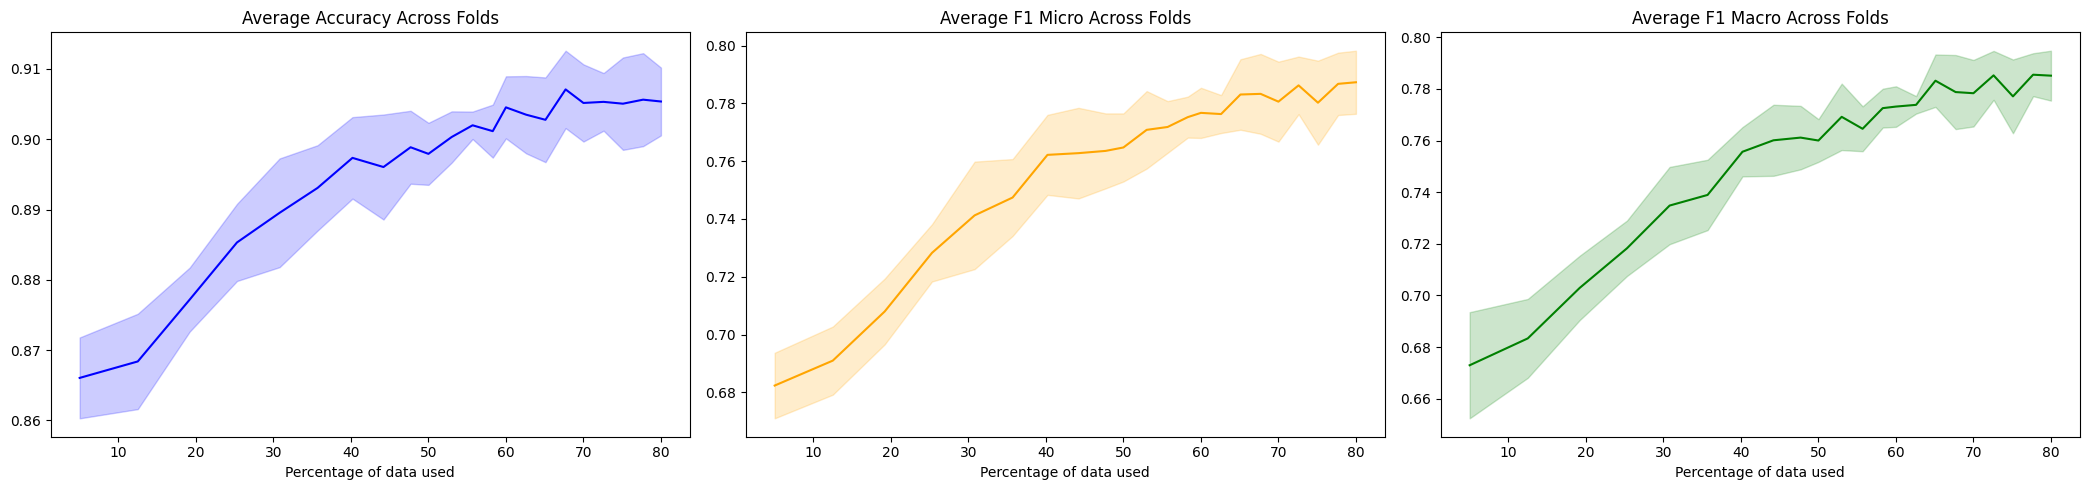

In [15]:
import matplotlib.pyplot as plt
import numpy as np

common_data_points = sorted(list(set(point for fold_points in all_fold_data_used for point in fold_points)))

# Interpolate metrics for each fold to the common data points
avg_accuracies = []
avg_f1_micros = []
avg_f1_macros = []
std_accuracies = []
std_f1_micros = []
std_f1_macros = []

for point in common_data_points:
    point_accuracies = []
    point_f1_micros = []
    point_f1_macros = []
    for i in range(3):
        sorted_indices = np.argsort(all_fold_data_used[i])
        sorted_data = np.array(all_fold_data_used[i])[sorted_indices]
        
        sorted_acc = np.array(all_fold_accuracies[i])[sorted_indices]
        sorted_f1m = np.array(all_fold_f1_micros[i])[sorted_indices]
        sorted_f1ma = np.array(all_fold_f1_macros[i])[sorted_indices]
        
        # Use interpolation to estimate the metric value at the common 'point'
        point_accuracies.append(np.interp(point, sorted_data, sorted_acc))
        point_f1_micros.append(np.interp(point, sorted_data, sorted_f1m))
        point_f1_macros.append(np.interp(point, sorted_data, sorted_f1ma))
    
    avg_accuracies.append(np.mean(point_accuracies))
    avg_f1_micros.append(np.mean(point_f1_micros))
    avg_f1_macros.append(np.mean(point_f1_macros))
    
    std_accuracies.append(np.std(point_accuracies))
    std_f1_micros.append(np.std(point_f1_micros))
    std_f1_macros.append(np.std(point_f1_macros))

# Convert to numpy arrays for easier plotting
avg_accuracies = np.array(avg_accuracies)
avg_f1_micros = np.array(avg_f1_micros)
avg_f1_macros = np.array(avg_f1_macros)
std_accuracies = np.array(std_accuracies)
std_f1_micros = np.array(std_f1_micros)
std_f1_macros = np.array(std_f1_macros)

fig, axs = plt.subplots(1, 3, figsize=(21, 5))
data_used_percent = [round(data / len(X) * 100, 1) for data in common_data_points]

# Plot for Accuracy
axs[0].plot(data_used_percent, avg_accuracies, label="Avg Accuracy", color="blue")
axs[0].fill_between(data_used_percent, avg_accuracies - std_accuracies, avg_accuracies + std_accuracies, color='blue', alpha=0.2)
axs[0].set_xlabel("Percentage of data used")
axs[0].set_title("Average Accuracy Across Folds")

# Plot for F1 Micro
axs[1].plot(data_used_percent, avg_f1_micros, label="Avg F1 Micro", color="orange")
axs[1].fill_between(data_used_percent, avg_f1_micros - std_f1_micros, avg_f1_micros + std_f1_micros, color='orange', alpha=0.2)
axs[1].set_xlabel("Percentage of data used")
axs[1].set_title("Average F1 Micro Across Folds")

# Plot for F1 Macro
axs[2].plot(data_used_percent, avg_f1_macros, label="Avg F1 Macro", color="green")
axs[2].fill_between(data_used_percent, avg_f1_macros - std_f1_macros, avg_f1_macros + std_f1_macros, color='green', alpha=0.2)
axs[2].set_xlabel("Percentage of data used")
axs[2].set_title("Average F1 Macro Across Folds")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

for i in range(3):
    result = pd.DataFrame({
        'Data Used': all_fold_data_used[i],
        'Accuracy': all_fold_accuracies[i],
        'F1 Micro': all_fold_f1_micros[i],
        'F1 Macro': all_fold_f1_macros[i],
    })

    result.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)